## Imports

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import operator

!pip install dython
from dython.nominal import associations

# Important imports for modeling and evaluation
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Set the option to show all rows.
pd.set_option('display.max_columns', None)

# Load the dataset.
students = pd.read_csv('/kaggle/input/higher-education-predictors-of-student-retention/dataset.csv')

## Data exploration and cleaning

In [3]:
# Show first five rows.
students.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


The data in most columns is encoded, the specification is provided below.

In [4]:
students.shape

(4424, 35)

There are 35 columns and 4,424 rows in the dataset.

In [5]:
# Gather basic information about the data.
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

Ranking in certain columns does not make sence and encoding were made for simplification.

In [6]:
students.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)

In [7]:
# Rename column Nacionality.
students.rename(columns={'Nacionality': 'Nationality'}, inplace=True)

# Get all categorical variables except target.
cat_cols = ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 
          'Previous qualification', 'Nationality', "Mother's qualification", "Father's qualification", 
          "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 
          'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']

# Get all continuous variables.
cont_cols = ['Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 
             'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 
             'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 
             'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 
             'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 
             'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 
             'Unemployment rate', 'Inflation rate', 'GDP']

# Change categorical columns to category datatype.
students[cat_cols] = students[cat_cols].astype('category')

In [8]:
students.describe()

,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,23.265145,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,7.587816,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,20.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,25.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [9]:
students.describe(include=['category', 'O'])

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International,Target
count,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424
unique,6,18,8,17,2,17,21,29,34,32,46,2,2,2,2,2,2,2,3
top,1,1,1,12,1,1,1,1,27,10,10,1,0,0,1,0,0,0,Graduate
freq,3919,1708,3026,766,3941,3717,4314,1069,1209,1577,1010,2426,4373,3921,3896,2868,3325,4314,2209


In [10]:
# Check for missing values.
students.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nationality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                     0
Curricular u

There is no missing data according to the results from `isna()` function.

In [11]:
# Check for duplicates.
students.duplicated().sum()

0

There is no duplicated data according to the results from `duplicated()` function.

## Exploratory data analysis

Make a copy of existing dataset, so we can perform manipulations without affecting the original dataset.

In [12]:
df = students.copy()

In [13]:
# Let's use this color palette.
sns.color_palette('muted')

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [14]:
# Adjust some seaborn settings.
colors = sns.color_palette('muted')
sns.set_palette('muted')
sns.set_style('ticks')
sns.set_style({'axes.facecolor':'white', 'grid.color': '.8'})

# Assign each categorical variable its own color.
colors_gender = {'Female': colors[0], 'Male': colors[1]}
colors_attendance = {'Evening': colors[0], 'Daytime': colors[1]}
colors_binary = {'Yes': colors[0], 'No': colors[1]}
colors_target = {'Graduate': colors[-1], 'Dropout': colors[-2], 'Enrolled': colors[4]}

### Target

First, we will explore our `Target` variable, which we will predict by our model.

In [15]:
# Show all unique values of target variable.
df['Target'].unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

Create a pie chart that depicts the proportions of total number of dropout, total number of graduated, and total number of enrolled students.\
Create a bar chart that shows the total number of dropout, total number of graduated, and total number of enrolled students.

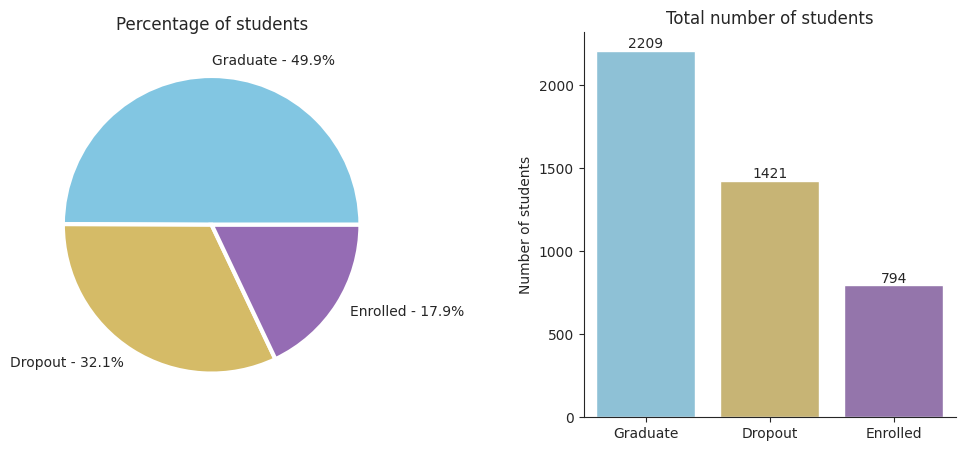

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.5)

data = df['Target'].value_counts()

# Create a pie chart.
labels = [f'{label} - {np.round(data[label] / data.sum() * 100, 1)}%' for label in data.index]
ax1.pie(data, labels=labels, wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'}, 
        colors=[colors_target.get(i) for i in data.index])
ax1.set_title('Percentage of students')

# Create a bar plot.
ax2 = sns.barplot(data=data.to_frame(), y='count', x=data.index, palette=colors_target)
ax2.set(xlabel=None, ylabel='Number of students')
ax2.bar_label(container=ax2.containers[0], labels=df['Target'].value_counts())
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_title('Total number of students')

plt.show()

The number of graduated students is more than the number of dropout students.\
The total number of graduated and dropout students is 2209 + 1421 = 3630, which is the number of observations for building our model.\
There are currently enrolled 18% of the total number of students or 794, the number students we will use our model for.

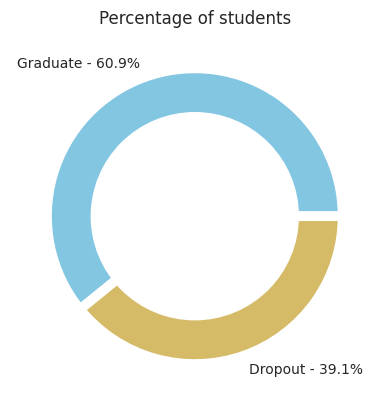

In [17]:
# Exclude currently enrolled students.
data = df[df['Target'] != 'Enrolled']['Target'].value_counts()

# Create a pie chart.
circle = plt.Circle((0,0), 0.7, color='white')
labels = [f'{label} - {np.round(data[label] / data.sum() * 100, 1)}%' for label in data.index]
plt.pie(data, labels=labels, wedgeprops = {'linewidth' : 7, 'edgecolor' : 'white'}, 
        colors=[colors_target.get(i) for i in data.index])
plt.title('Percentage of students')
p = plt.gcf()
p.gca().add_artist(circle)
plt.show()

By looking at the pie chart we can suggest that every 6 out of 10 students were successfully graduated, on the other hand every 4 out of 10 students were dropped out. In other words, each $3^{rd}$ student might be in a risk of dropping out of the course.

### Gender

Explore `Gender` variable, look for patterns, investigate its relation to the target variable.

In [18]:
# Replace 0 and 1 values with Female and Male respectively.
df = df.replace({'Gender': {0: 'Female', 1: 'Male'}})

Create a pie chart that depicts the proportions of total number of female, and total number of male students.\
Create a bar chart that shows the total number of female, and total number of male students.

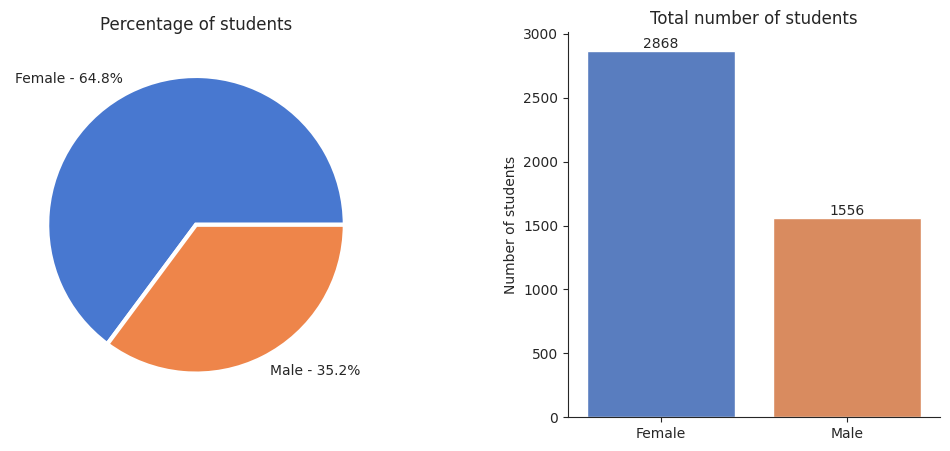

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.5)

data = df['Gender'].value_counts()

# Create a pie chart.
labels = [f'{label} - {np.round(data[label] / data.sum() * 100, 1)}%' for label in data.index]
ax1.pie(data, labels=labels, wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'}, 
        colors=[colors_gender.get(i) for i in data.index])
ax1.set_title('Percentage of students')

# Create a bar plot.
ax2 = sns.barplot(data=data.to_frame(), y='count', x=data.index, palette=colors_gender)
ax2.set(xlabel=None, ylabel='Number of students')
ax2.bar_label(container=ax2.containers[0], labels=df['Gender'].value_counts())
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_title('Total number of students')

plt.show()

There are more female students than male students in the dataset.\
The number of female students is 30% higher.\
The dataset is slightly imbalanced, however it should not significantly affect the future model.

Create a stacked bar chart that shows the total number of dropout, total number of graduated, and total number of enrolled students in both gender groups.\
Create a pie chart that depicts the proportions of total number of dropout and total number of graduated female students.\
Create a pie chart that depicts the proportions of total number of dropout and total number of graduated male students.

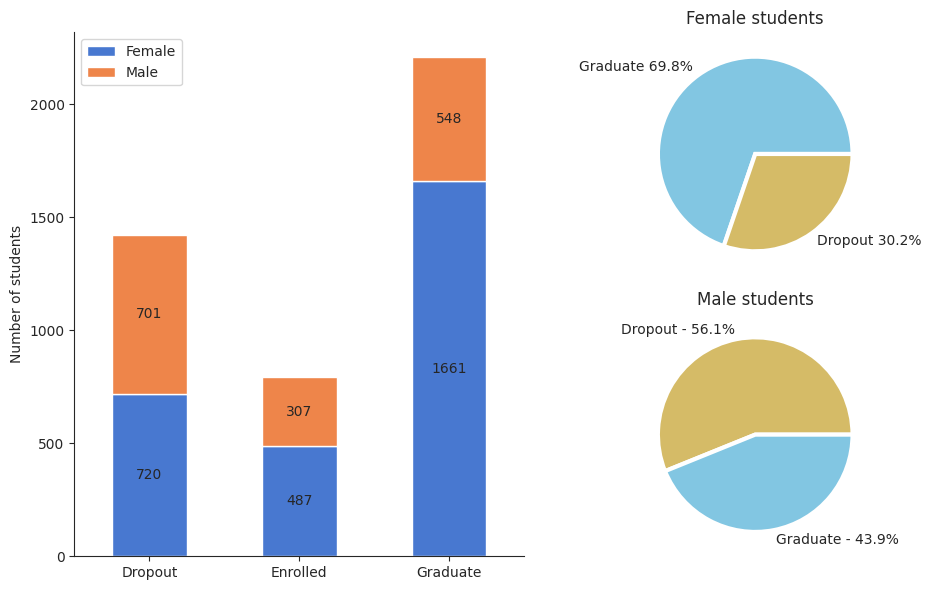

In [20]:
fig = plt.figure(figsize=(10, 6), tight_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2)

# Create a stacked barchart.
ax1 = fig.add_subplot(gs[:, 0])
data = df.groupby(['Gender', 'Target']).size().reset_index().pivot(columns='Gender', index='Target', values=0)
data.plot(ax=ax1, kind='bar', stacked=True, color=[colors_gender.get(i) for i in data.columns])
for cont in ax1.containers:
    ax1.bar_label(cont, label_type='center')
ax1.spines[['right', 'top']].set_visible(False)
ax1.set(xlabel=None, ylabel='Number of students')
ax1.legend_.set_title(None)
plt.xticks(rotation=0)
    
# Create a pie chart for female students.
females = df[(df['Gender'] == 'Female') & (df['Target'] != 'Enrolled')]['Target'].value_counts()
labels = [f'{label} {np.round(females[label] / females.sum() * 100, 1)}%' for label in females.index]
ax2 = fig.add_subplot(gs[0, 1])
patches, texts = ax2.pie(females, labels=labels, colors=[colors_target.get(i) for i in females.index], 
        wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'})
ax2.set(title='Female students')

# Create a pie chart for male students.
males = df[(df['Gender'] == 'Male') & (df['Target'] != 'Enrolled')]['Target'].value_counts()
labels = [f'{label} - {np.round(males[label] / males.sum() * 100, 1)}%' for label in males.index]
ax3 = fig.add_subplot(gs[1, 1])
ax3.pie(males, labels=labels, colors=[colors_target.get(i) for i in males.index], 
        wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'})
ax3.set(title='Male students')
    
plt.show()

The number of dropout female and male students is almost equal.\
There are enrolled slightly more female students than male students.\
The number of graduated female students is around 3 times higher than male students.\
The female students graduation rate is higher than the graduation rate for male students.\
On the other hand, the percentage of dropout male students is higher than the percentage of graduated male students (56% and 44% respectively).

### Age at enrollment

Explore `Age at enrollment` variable, look for patterns, investigate its relation to the target variable.

Create a box plot and histogram that show the distribution of students age.

In [21]:
# Find the optimal number of bins using Sturges’ rule.
bins = int(math.ceil(math.log2(len(df))) + 1)
age_min = df['Age at enrollment'].min()
age_max = df['Age at enrollment'].max()
bin_int = df['Age at enrollment'].max() // bins
bin_edges = [i for i in range(age_min, age_max + bin_int, bin_int)]

# Perform binning on Age at enrollment column.
age_labels = [f'{bin_edges[i]}-{bin_edges[i + 1]}' for i in range(len(bin_edges) - 1)]
df['Age at enrollment bins'] = pd.cut(df['Age at enrollment'], bin_edges, labels=age_labels)

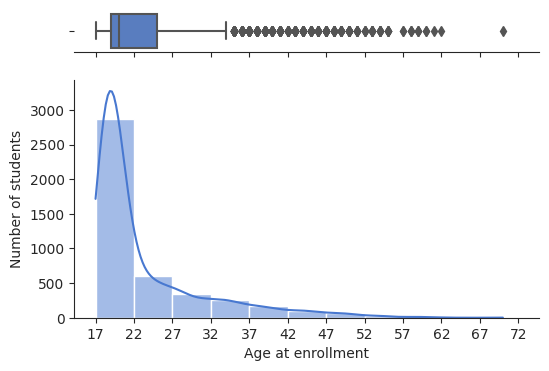

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6, 4), gridspec_kw={"height_ratios": (.15, .85)})

# Create a boxplot.
ax1 = sns.boxplot(data=df, x='Age at enrollment', ax=ax1)
ax1.set(xlabel=None)

# Create a histogram.
labels = df['Age at enrollment'].value_counts()
labels = [f'{label} - {round(males[label] / males.sum() * 100)}%' for label in males.index]
ax2 = sns.histplot(data=df, x='Age at enrollment', ax=ax2, bins=bins, binwidth=bin_int, kde=True)
ax2.set(ylabel='Number of students')
sns.despine(ax=ax1, left=True)
sns.despine(ax=ax2)


# Adjust x ticks.
plt.xticks(bin_edges)
plt.show()

The vast majority of students are 17-22 years old.\
The number of students decreases as the students age increases.

Create a histogram that shows the distribution of students age of dropout, graduated, and enrolled students.\
Create a stacked bar plot that shows the proportion of dropout, and enrolled students in different age groups.

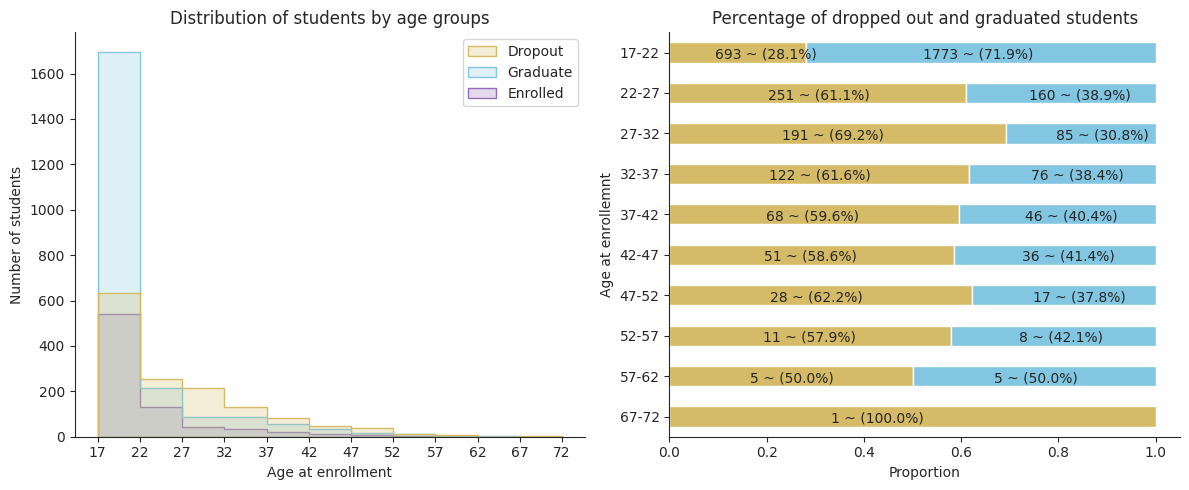

In [23]:
fig = plt.figure(figsize=(12, 5), tight_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=2)

# Create a histogram.
ax1 = fig.add_subplot(gs[0, 0])
ax1 = sns.histplot(data=df, x='Age at enrollment', hue='Target', element='step', bins=bins, 
                  binwidth=bin_int, palette=colors_target)
ax1.set(ylabel='Number of students')
ax1.legend_.set_title(None)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_title('Distribution of students by age groups')
plt.xticks([i for i in range(age_min, age_max + bin_int, bin_int)])

# Create a stacked bar plot.
ax2 = fig.add_subplot(gs[0, 1])
data = pd.crosstab(index=df['Age at enrollment bins'], columns=df[df['Target'] != 'Enrolled']['Target'])
data_prop = pd.crosstab(index=df['Age at enrollment bins'], columns=df[df['Target'] != 'Enrolled']['Target'], normalize='index')
labels = [i for i in age_labels if i in data.index]
data_prop.loc[labels[::-1]].plot(ax=ax2, kind='barh', stacked=True, color=[colors_target.get(i) for i in data.columns])
ax2.set(xlabel='Proportion', ylabel='Age at enrollemnt')
ax2.get_legend().remove()
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_title('Percentage of dropped out and graduated students')
plt.xticks(rotation=0)

for n, x in enumerate([*data.loc[labels[::-1]].index.values]):
    for (proportion, count, y_loc) in zip(data_prop.loc[x], data.loc[x], data_prop.loc[x].cumsum()):
        if proportion:
            plt.text(x=(y_loc - proportion) + (proportion / 3), y=n - 0.15, s=f'{count} ~ ({np.round(proportion * 100, 1)}%)')
        
plt.show()

The highest graduation rate has the age group 17-22 with 72% of graduated students and 28% of dropped out srudents.\
There is no definitive distinction between other age groups, except 67-72 where only 1 student was dropped out.

### Nationality

Explore `Nationality` variable, look for patterns, investigate its relation to the target variable and determine whether it is good for prediction or not.

In [24]:
# Replace numerical values with their verbal analogs.
df[['Nationality']] = df[['Nationality']].replace({'Nationality': {1: 'Portuguese', 2: 'German', 3: 'Spanish', 
                                                               4: 'Italian', 5: 'Dutch', 6: 'English', 
                                                               7: 'Lithuanian', 8: 'Angolan', 9: 'Cape Verdean', 
                                                               10: 'Guinean', 11: 'Mozambican', 12: 'Santomean', 
                                                               13: 'Turkish', 14: 'Brazilian', 15: 'Romanian', 
                                                               16: 'Moldovan', 17: 'Mexican', 18: 'Ukrainian', 
                                                               19: 'Russian', 20: 'Cuban', 21: 'Colombian'}})

From the descriptive statistics we can see that one particular nationality appears 4,314. This is almost 98% of the whole dataset.

Create a count chart that depicts the total number of dropout students, graduate students, and enrolled students based on nationality.

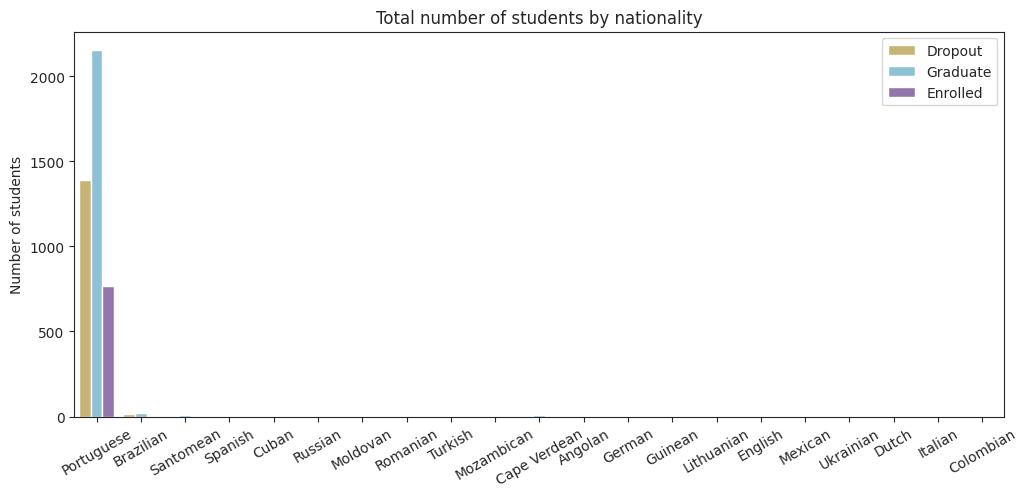

In [25]:
# Create a count plot.
fig, ax = plt.subplots(figsize=(12, 5))
order = df[df['Target'] == 'Enrolled']['Nationality'].value_counts()
ax = sns.countplot(data=df, x='Nationality', hue='Target', palette=colors_target, order=order.index)
ax.set(xlabel=None, ylabel='Number of students', title='Total number of students by nationality')
plt.xticks(rotation=30)
ax.legend_.set_title(None)
plt.show()

The vast majority of students are Portuguese. The variable `Nationality` is highly imbalanced.

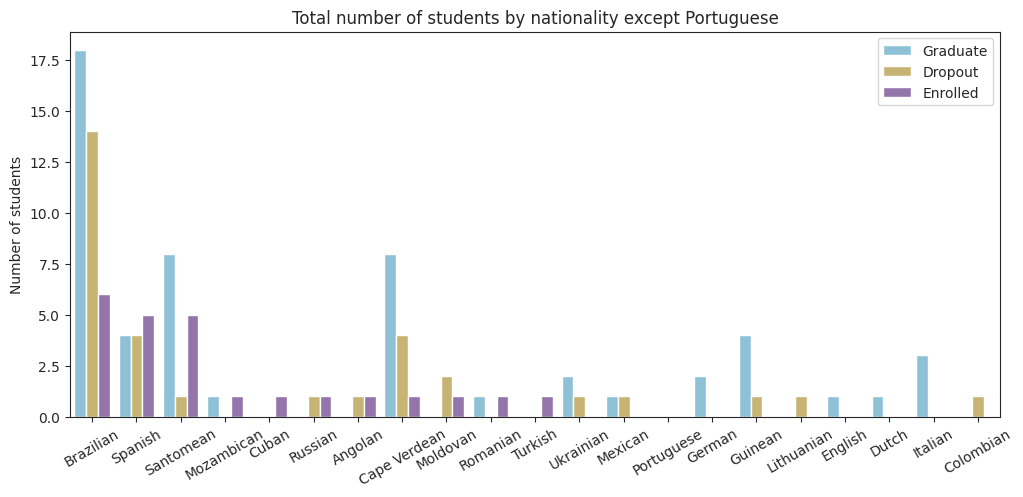

In [26]:
# Create a count plot wothout Portuguese students.
fig, ax = plt.subplots(figsize=(12, 5))
data = df[df['Nationality'] != 'Portuguese']
order = data[data['Target'] == 'Enrolled']['Nationality'].value_counts()
ax = sns.countplot(data=data, x='Nationality', hue='Target', palette=colors_target, order=order.index)
ax.set(xlabel=None, ylabel='Number of students', title='Total number of students by nationality except Portuguese')
plt.xticks(rotation=30)
ax.legend_.set_title(None)
plt.show()

There is no pattern to be seen in above plots.

### Marital status

Explore `Marital status` variable, look for patterns, investigate its relation to the target variable and determine whether it is good for prediction or not.

In [27]:
# Replace 1 - Single, 2 - Married, 3 - Widower, 4 - Divorced, 5 - Facto union, and 6 - Legally separated.
df = df.replace({'Marital status': {1: 'Single', 2: 'Married', 3: 'Widower', 4: 'Divorced', 
                                    5: 'Facto union', 6: 'Legally separated'}})

Create a barplot that shows the number of students in following marital status groups: single, married, divorced, facto union, widower, and legally.\
Create a stacked bar plot that shows the proportion of dropout, and enrolled students in different marital status groups.

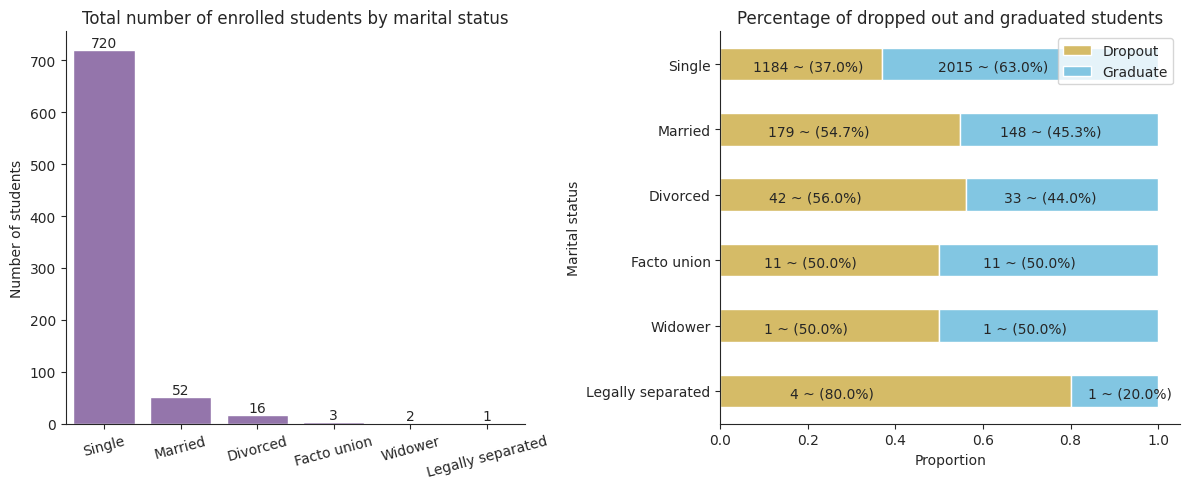

In [28]:
fig = plt.figure(figsize=(12, 5), tight_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=2)

# Create a bar plot.
ax1 = fig.add_subplot(gs[0, 0])
data = df[df['Target'] == 'Enrolled']['Marital status'].value_counts()
order = data.index
ax1 = sns.barplot(data=data.to_frame(), y='count', x=data.index, color=colors[4], order=order)
ax1.set(xlabel=None, ylabel='Number of students')
ax1.bar_label(container=ax1.containers[0], labels=data)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_title('Total number of enrolled students by marital status')
plt.xticks(rotation=15)

# Create a stacked bar plot.
ax2 = fig.add_subplot(gs[0, 1])
data = pd.crosstab(index=df['Marital status'], columns=df[df['Target'] != 'Enrolled']['Target'])
data_prop = pd.crosstab(index=df['Marital status'], columns=df[df['Target'] != 'Enrolled']['Target'], normalize='index')
data_prop.loc[order[::-1]].plot(ax=ax2, kind='barh', stacked=True, color=[colors_target.get(i) for i in data.columns])
ax2.set(xlabel='Proportion', ylabel='Marital status')
ax2.spines[['right', 'top']].set_visible(False)
ax2.legend_.set_title(None)
ax2.set_title('Percentage of dropped out and graduated students')
plt.xticks(rotation=0)

for n, x in enumerate([*data.loc[order[::-1]].index.values]):
    for (proportion, count, y_loc) in zip(data_prop.loc[x], data.loc[x], data_prop.loc[x].cumsum()):
        plt.text(x=(y_loc - proportion) + (proportion / 5), y=n - 0.1, s=f'{count} ~ ({np.round(proportion * 100, 1)}%)')

plt.show()

The majority of enrolled students are single.\
The percentage of single students who graduated is higher than the percentage of students who dropped out.\
Students with a marital status `Legally separated` have the highest percentage of dropouts.\
The distribution of droput and graduate students within other groups is similar and no pattern can be seen.

### Application mode

Explore `Application mode` variable, look for patterns, investigate its relation to the target variable and determine whether it is good for prediction or not.

Create a barplot that shows the number of students based on the application mode.\
Create a stacked bar plot that shows the proportion of dropout, and enrolled students in different application mode groups.

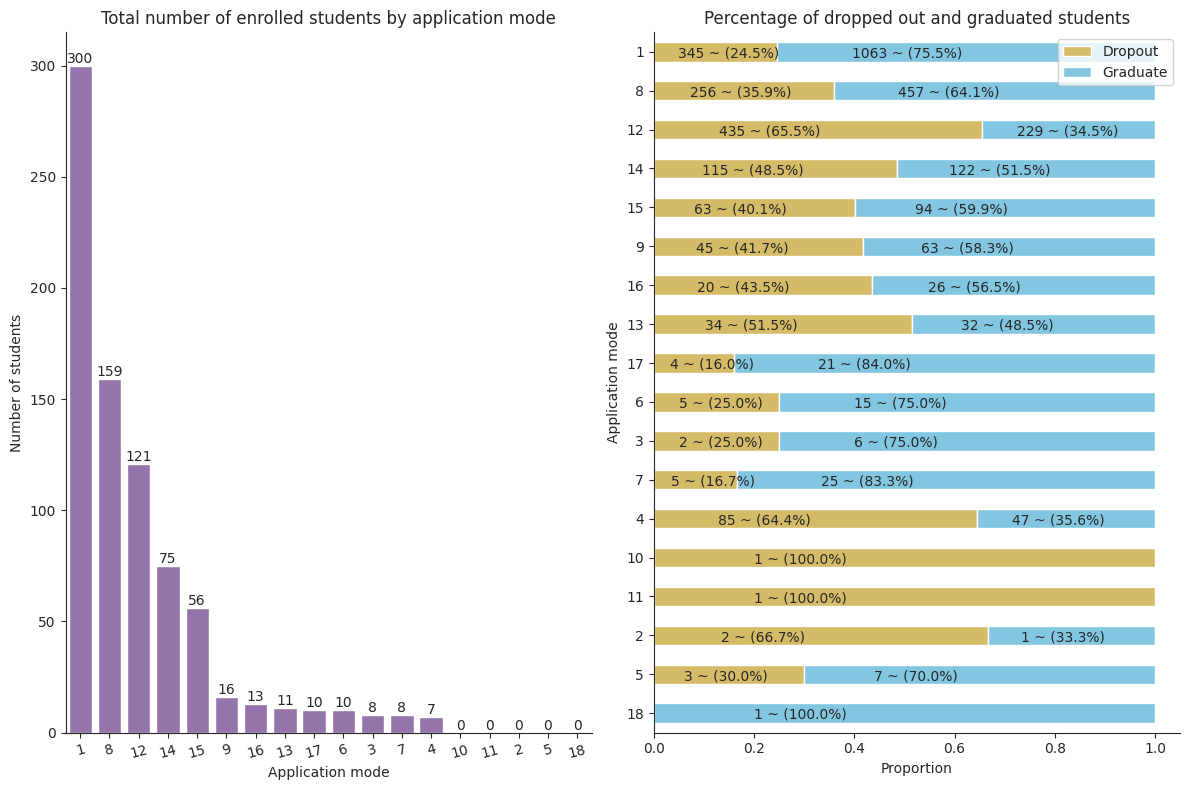

In [29]:
fig = plt.figure(figsize=(12, 8), tight_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=2)

# Create a bar plot.
ax1 = fig.add_subplot(gs[0, 0])
data = df[df['Target'] == 'Enrolled']['Application mode'].value_counts()
order = data.index
ax1 = sns.barplot(data=data.to_frame(), y='count', x=data.index, color=colors[4], order=order)
ax1.set(xlabel='Application mode', ylabel='Number of students')
ax1.bar_label(container=ax1.containers[0], labels=data)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_title('Total number of enrolled students by application mode')
plt.xticks(rotation=15)

# Create a stacked bar plot.
ax2 = fig.add_subplot(gs[0, 1])
data = pd.crosstab(index=df['Application mode'], columns=df[df['Target'] != 'Enrolled']['Target'])
data_prop = pd.crosstab(index=df['Application mode'], columns=df[df['Target'] != 'Enrolled']['Target'], normalize='index')
data_prop.loc[order[::-1]].plot(ax=ax2, kind='barh', stacked=True, color=[colors_target.get(i) for i in data.columns])
ax2.set(xlabel='Proportion', ylabel='Application mode')
ax2.spines[['right', 'top']].set_visible(False)
ax2.legend_.set_title(None)
ax2.set_title('Percentage of dropped out and graduated students')
plt.xticks(rotation=0)

for n, x in enumerate([*data.loc[order[::-1]].index.values]):
    for (proportion, count, y_loc) in zip(data_prop.loc[x], data.loc[x], data_prop.loc[x].cumsum()):
        if proportion:
            plt.text(x=(y_loc - proportion) + (proportion / 5), y=n - 0.15, s=f'{count} ~ ({np.round(proportion * 100, 1)}%)')

plt.show()

The majority of currently enrolled students has `1st phase - general contingent` (1) application mode and the graduation rate of these students is 75.5%.\
Students with application mode encoded as 8 have 64.1% of graduation rate, whereas students with application mode encoded as 12 have 65.5% drop out rate.

### Application order

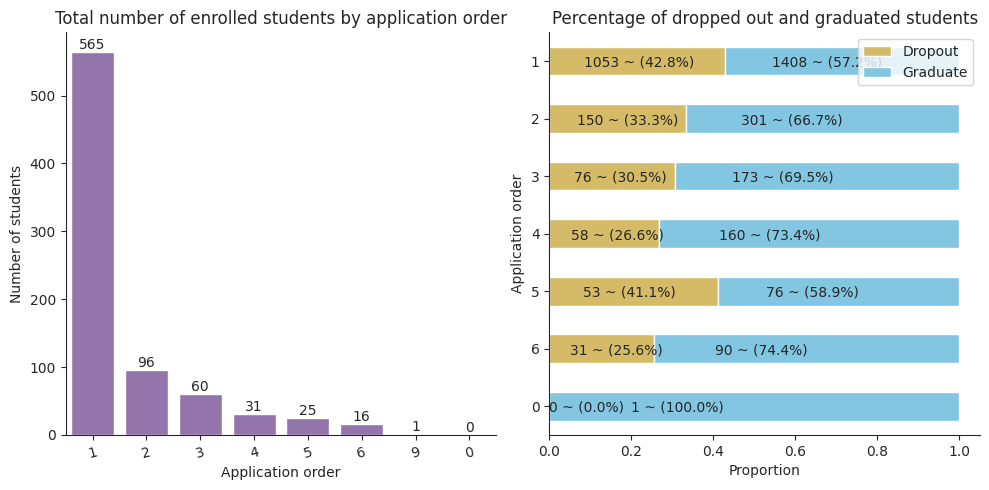

In [30]:
fig = plt.figure(figsize=(10, 5), tight_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=2)

# Create a bar plot.
ax1 = fig.add_subplot(gs[0, 0])
data = df[df['Target'] == 'Enrolled']['Application order'].value_counts()
order = data.index
ax1 = sns.barplot(data=data.to_frame(), y='count', x=data.index, color=colors[4], order=order)
ax1.set(xlabel='Application order', ylabel='Number of students')
ax1.bar_label(container=ax1.containers[0], labels=data)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_title('Total number of enrolled students by application order')
plt.xticks(rotation=15)

# Create a stacked bar plot.
ax2 = fig.add_subplot(gs[0, 1])
data = pd.crosstab(index=df['Application order'], columns=df[df['Target'] != 'Enrolled']['Target'])
data_prop = pd.crosstab(index=df['Application order'], columns=df[df['Target'] != 'Enrolled']['Target'], normalize='index')
labels = [i for i in order if i in data.index]
data_prop.loc[labels[::-1]].plot(ax=ax2, kind='barh', stacked=True, color=[colors_target.get(i) for i in data.columns])
ax2.set(xlabel='Proportion', ylabel='Application order')
ax2.spines[['right', 'top']].set_visible(False)
ax2.legend_.set_title(None)
ax2.set_title('Percentage of dropped out and graduated students')
plt.xticks(rotation=0)

for n, x in enumerate([*data.loc[labels[::-1]].index.values]):
    for (proportion, count, y_loc) in zip(data_prop.loc[x], data.loc[x], data_prop.loc[x].cumsum()):
        plt.text(x=(y_loc - proportion) + (proportion / 5), y=n - 0.1, s=f'{count} ~ ({np.round(proportion * 100, 1)}%)')

plt.show()

### Daytime/evening attendance

Explore `Daytime/evening` attendance variable, look for patterns, investigate its relation to the target variable and determine whether it is good for prediction or not.

In [31]:
# Replace 0 and 1 values with Female and Male respectively.
df = df.replace({'Daytime/evening attendance': {0: 'Evening', 1: 'Daytime'}})

Create a pie chart that depicts the proportions of total number of daytime, and total number of evening students.\
Create a bar chart that shows the total number of daytime, and total number of evening students.

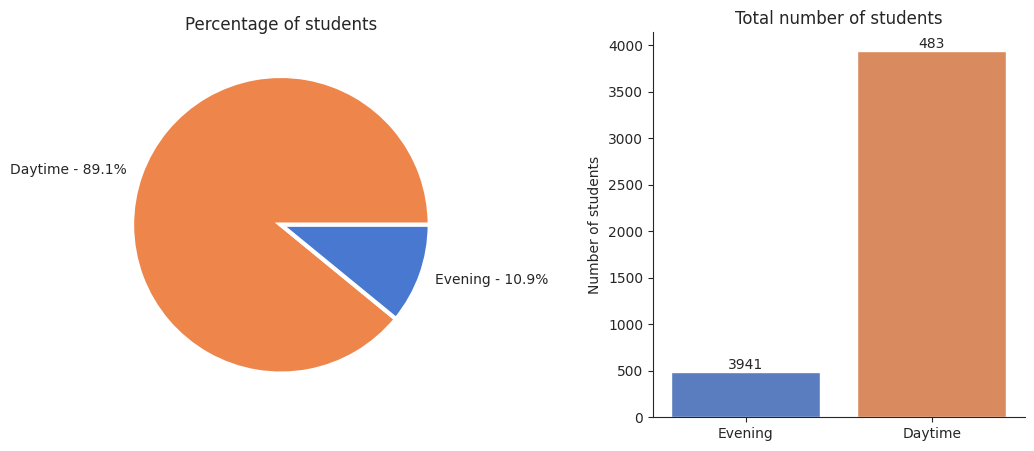

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.5)

data = df['Daytime/evening attendance'].value_counts()

# Create a pie chart.
labels = [f'{label} - {np.round(data[label] / data.sum() * 100, 1)}%' for label in data.index]
ax1.pie(data, labels=labels, colors=[colors_attendance.get(i) for i in data.index], 
        wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'})
ax1.set_title('Percentage of students')

# Create a bar plot.
ax2 = sns.barplot(data=data.to_frame(), y='count', x=data.index, palette=colors_attendance)
ax2.set(xlabel=None, ylabel='Number of students')
ax2.bar_label(container=ax2.containers[0], labels=df['Daytime/evening attendance'].value_counts())
ax2.set_title('Total number of students')
ax2.spines[['right', 'top']].set_visible(False)

plt.show()

The vast majority of students studies during the day (89%).

Create a stacked bar chart that shows the total number of dropout, total number of graduated, and total number of enrolled students in daytime attendance and evening attendance groups.\
Create a pie chart that depicts the proportions of total number of dropout and total number of graduated daytime students.\
Create a pie chart that depicts the proportions of total number of dropout and total number of graduated evening students.

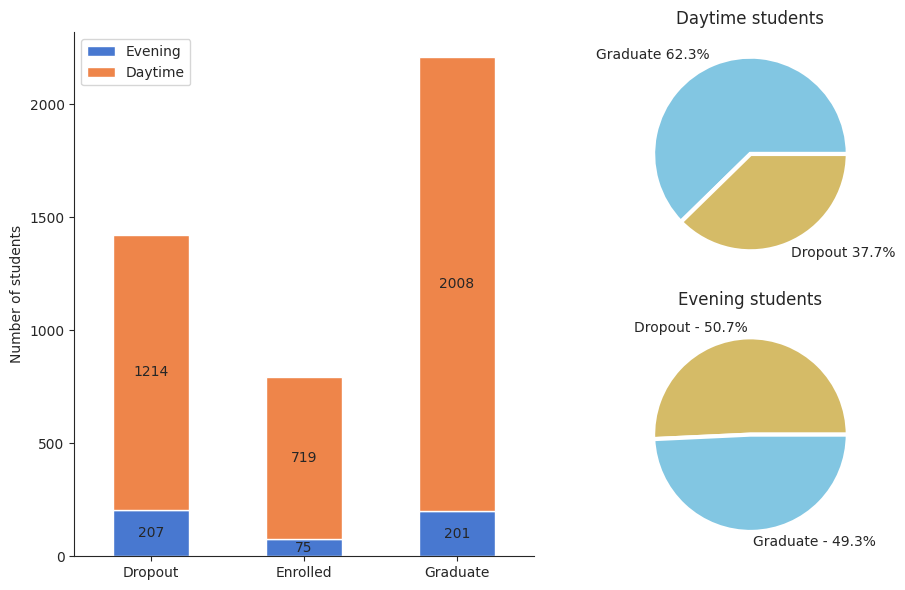

In [33]:
fig = plt.figure(figsize=(10, 6), tight_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2)

# Create a stacked barchart.
ax1 = fig.add_subplot(gs[:, 0])
data = df.groupby(['Daytime/evening attendance', 
                   'Target']).size().reset_index().pivot(columns='Daytime/evening attendance', index='Target', values=0)
data.plot(ax=ax1, kind='bar', stacked=True, color=[colors_attendance.get(i) for i in data.columns])
for cont in ax1.containers:
    ax1.bar_label(cont, label_type='center')
ax1.spines[['right', 'top']].set_visible(False)
ax1.set(xlabel=None, ylabel='Number of students')
ax1.legend_.set_title(None)
plt.xticks(rotation=0)
    
# Create a pie chart for daytime students.
daytime = df[(df['Daytime/evening attendance'] == 'Daytime') & (df['Target'] != 'Enrolled')]['Target'].value_counts()
labels = [f'{label} {np.round(daytime[label] / daytime.sum() * 100, 1)}%' for label in daytime.index]
ax2 = fig.add_subplot(gs[0, 1])
patches, texts = ax2.pie(daytime, labels=labels, colors=[colors_target.get(i) for i in daytime.index], 
        wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'})
ax2.set(title='Daytime students')

# Create a pie chart for evening students.
evening = df[(df['Daytime/evening attendance'] == 'Evening') & (df['Target'] != 'Enrolled')]['Target'].value_counts()
labels = [f'{label} - {np.round(evening[label] / evening.sum() * 100, 1)}%' for label in evening.index]
ax3 = fig.add_subplot(gs[1, 1])
ax3.pie(evening, labels=labels, colors=[colors_target.get(i) for i in evening.index], 
        wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'})
ax3.set(title='Evening students')
    
plt.show()

The graduation rate of daytime students is higher than the graduation rate of evening students, it is 62% against 49%. The difference is not significant.\
The variable `Daytime/evening attendance` is imbalanced: the number of daytime students is 719 against only 75 of evening students.
* It is not recommended to use `Daytime/evening attendance` as a predictor variable.

### Course

Explore `Course` variable, look for patterns, investigate its relation to the target variable and determine whether it is good for prediction or not.

In [34]:
# Replace numerical values with their verbal analogs.
df[['Course']] = df[['Course']].replace({'Course': {1: 'Biofuel Production Technologies', 2: 'Animation and Multimedia Design', 
                                                    3: 'Social Service (evening attendance)', 4: 'Agronomy', 
                                                    5: 'Communication Design', 6: 'Veterinary Design', 
                                                    7: 'Informatics Engineering', 8: 'Equiniculture', 9: 'Management', 
                                                    10: 'Social Service', 11: 'Tourism', 12: 'Nursing', 13: 'Oral Hygiene', 
                                                    14: 'Advertising and Marketing Management', 
                                                    15: 'Journalism and Communication', 16: 'Basic Education', 
                                                    17: 'Management (evening attendance)'}})

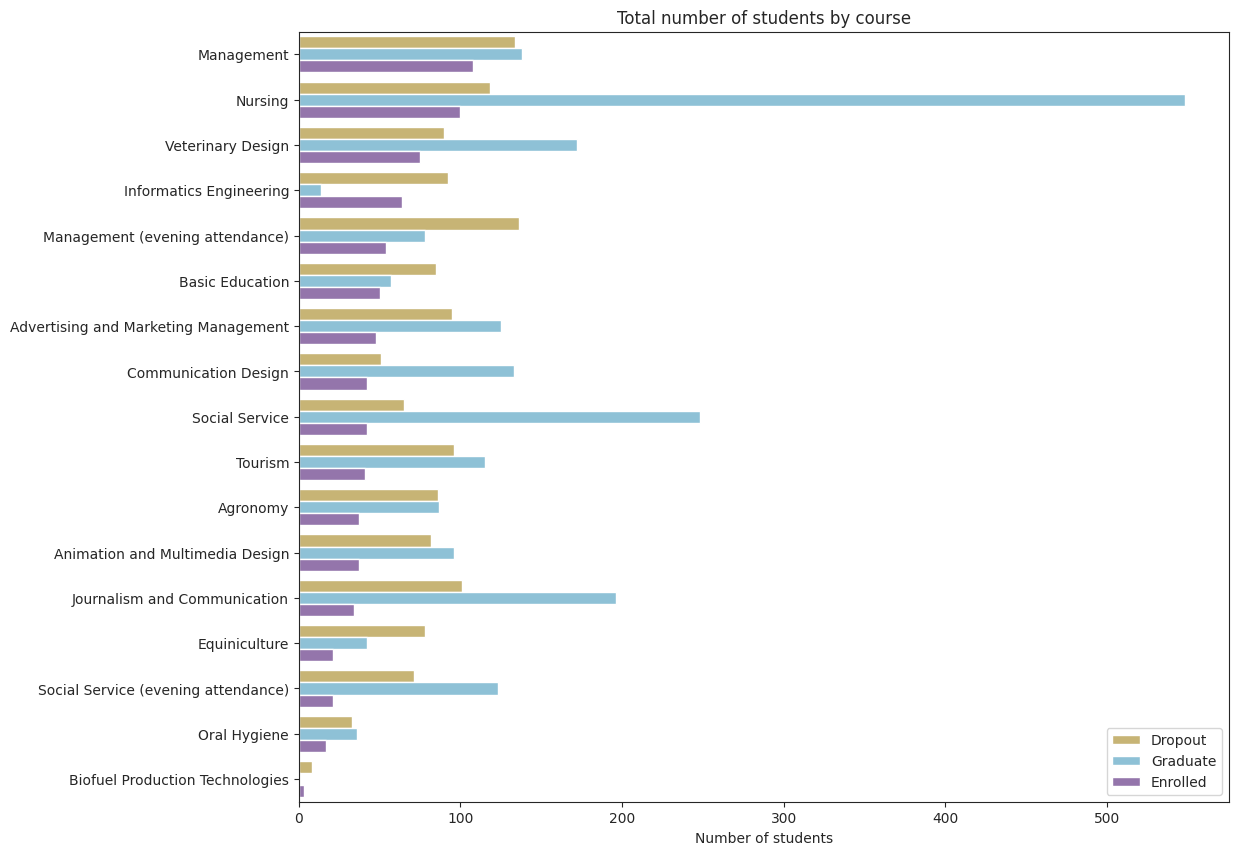

In [35]:
# Create a count plot.
fig, ax = plt.subplots(figsize=(12, 10))
order = df[df['Target'] == 'Enrolled']['Course'].value_counts().index
ax = sns.countplot(data=df, y='Course', hue='Target', palette=colors_target, order=order)
ax.set(xlabel='Number of students', ylabel=None, title='Total number of students by course')
ax.legend_.set_title(None)
plt.show()

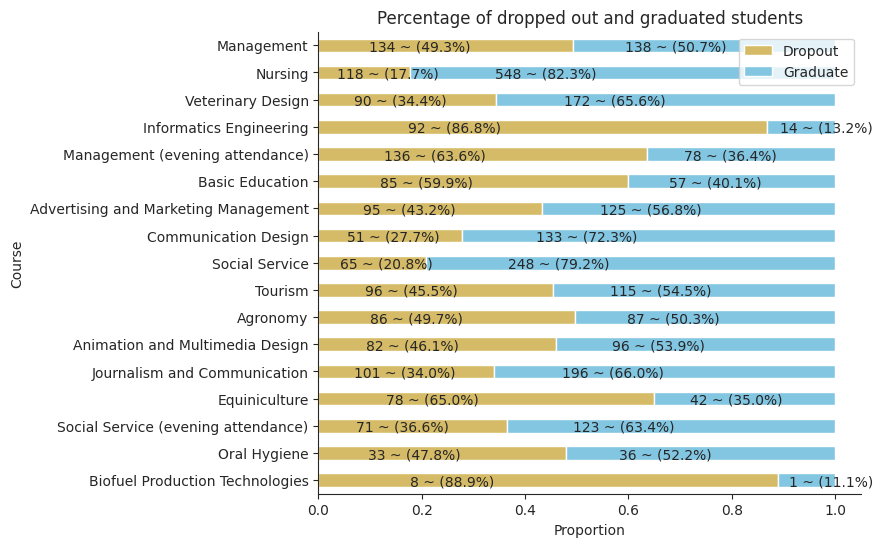

In [36]:
# Create a stacked bar plot.
data = pd.crosstab(index=df['Course'], columns=df[df['Target'] != 'Enrolled']['Target'])
data_prop = pd.crosstab(index=df['Course'], columns=df[df['Target'] != 'Enrolled']['Target'], normalize='index')
ax = data_prop.loc[order[::-1]].plot(kind='barh', stacked=True, 
                                     color=[colors_target.get(i) for i in data.columns], figsize=(7, 6))
ax.set(xlabel='Proportion', ylabel='Course')
ax.spines[['right', 'top']].set_visible(False)
ax.legend_.set_title(None)
ax.set_title('Percentage of dropped out and graduated students')
plt.xticks(rotation=0)

for n, x in enumerate([*data.loc[order[::-1]].index.values]):
    for (proportion, count, y_loc) in zip(data_prop.loc[x], data.loc[x], data_prop.loc[x].cumsum()):
        plt.text(x=(y_loc - proportion) + (proportion / 5), y=n - 0.2, s=f'{count} ~ ({np.round(proportion * 100, 1)}%)')

plt.show()

Most currently enrolled students are studying Management, however there is no big difference between numbers of currently enrolled students in different courses.\
The majority of students who successfully graduated were studying Nursing.\
The highest dropout rates are in Informatics Engineering and Biofuel Production Technologies courses with 86.8% and 88.9% respectively.
* In general, there is pattern and the percentage of dropout and graduate students in different courses does not stay the same and we can use the variable `Course` as a predictor for the model.

### Previous qualification

Explore `Previous qualification` variable, look for patterns, investigate its relation to the target variable and determine whether it is good for prediction or not.

From the descriptive statistics we can see that one particular qualification `Secondary education` appears 3,717. This is 84% of the whole dataset. Plot a count chart and see the distribution between qualifications.

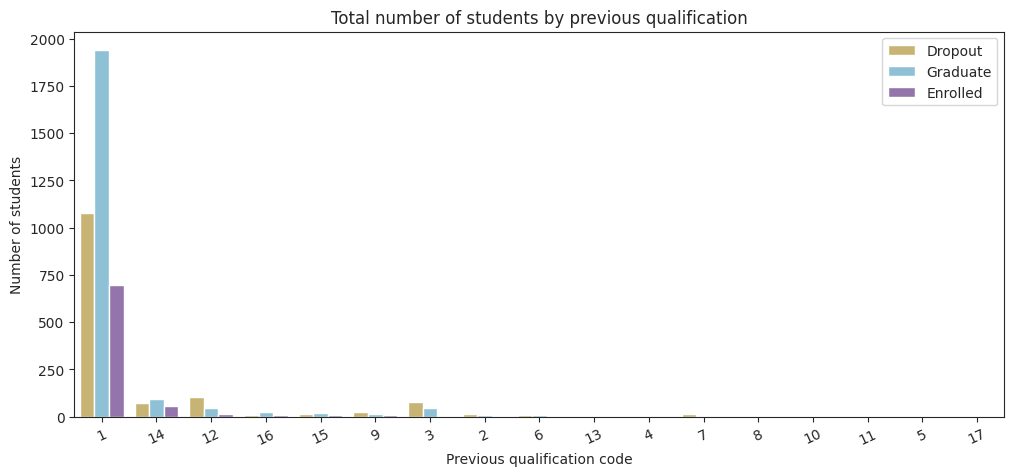

In [37]:
# Create a count plot.
fig, ax = plt.subplots(figsize=(12, 5))
order = df[df['Target'] == 'Enrolled']['Previous qualification'].value_counts()
ax = sns.countplot(data=df, x='Previous qualification', hue='Target', palette=colors_target, order=order.index)
ax.set(xlabel='Previous qualification code', ylabel='Number of students', 
       title='Total number of students by previous qualification')
plt.xticks(rotation=25)
ax.legend_.set_title(None)
plt.show()

The vast majority of students has secondary education (1) as previous qualification. The variable `Previous qualification` is highly imbalanced.

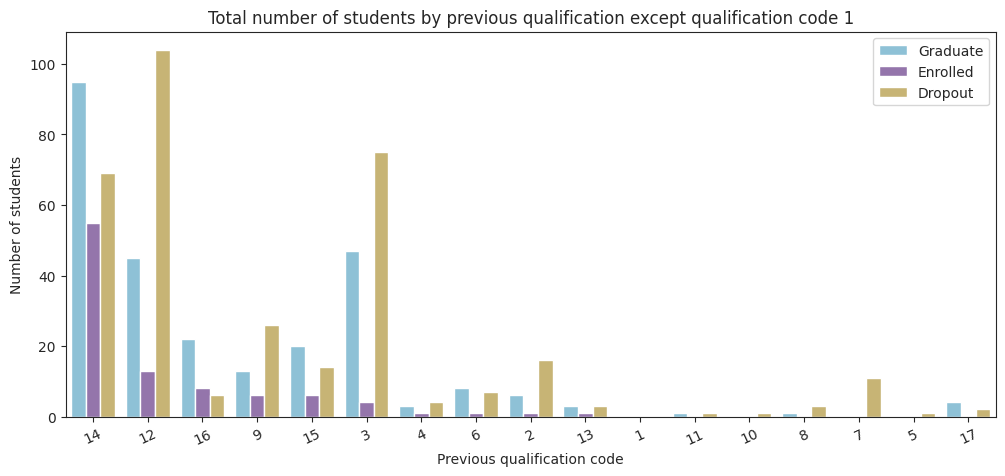

In [38]:
# Create a count plot wothout students with secondary education (1) as previous qualification.
fig, ax = plt.subplots(figsize=(12, 5))
data = df[df['Previous qualification'] != 1]
order = data[data['Target'] == 'Enrolled']['Previous qualification'].value_counts()
ax = sns.countplot(data=data, x='Previous qualification', hue='Target', palette=colors_target, order=order.index)
ax.set(xlabel='Previous qualification code', ylabel='Number of students', 
       title='Total number of students by previous qualification except qualification code 1')
plt.xticks(rotation=25)
ax.legend_.set_title(None)
plt.show()

There is no pattern to be seen in above plots.

### Mother's qualification, Father's qualification

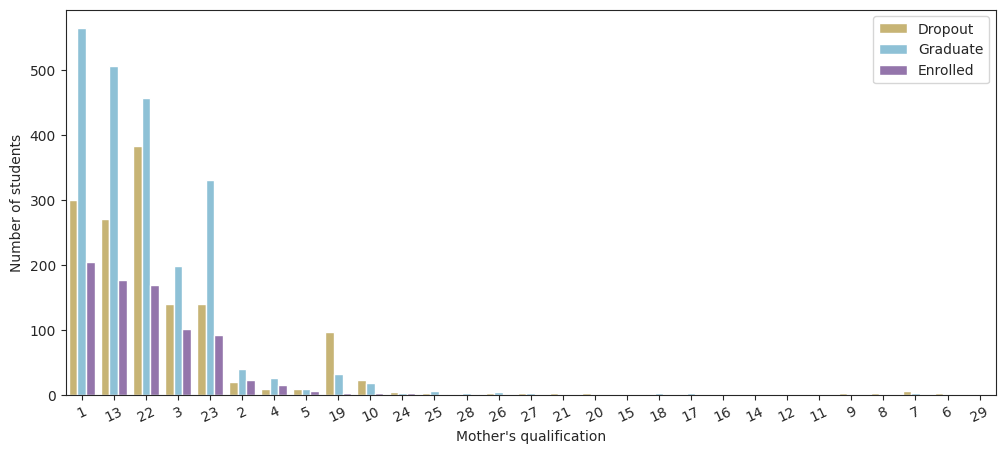

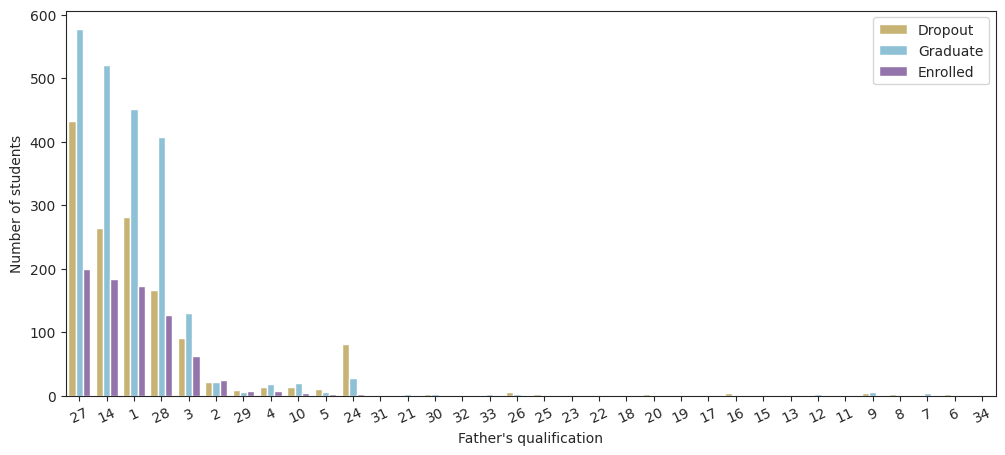

In [39]:
cols = ["Mother's qualification", "Father's qualification"]

# Create count plots.
for col in cols:
    fig, ax = plt.subplots(figsize=(12, 5))
    order = df[df['Target'] == 'Enrolled'][col].value_counts()
    ax = sns.countplot(data=df, x=col, hue='Target', palette=colors_target, order=order.index)
    ax.set(xlabel=col, ylabel='Number of students')
    plt.xticks(rotation=25)
    ax.legend_.set_title(None)
    plt.show()

### Mother's occupation, Father's occupation

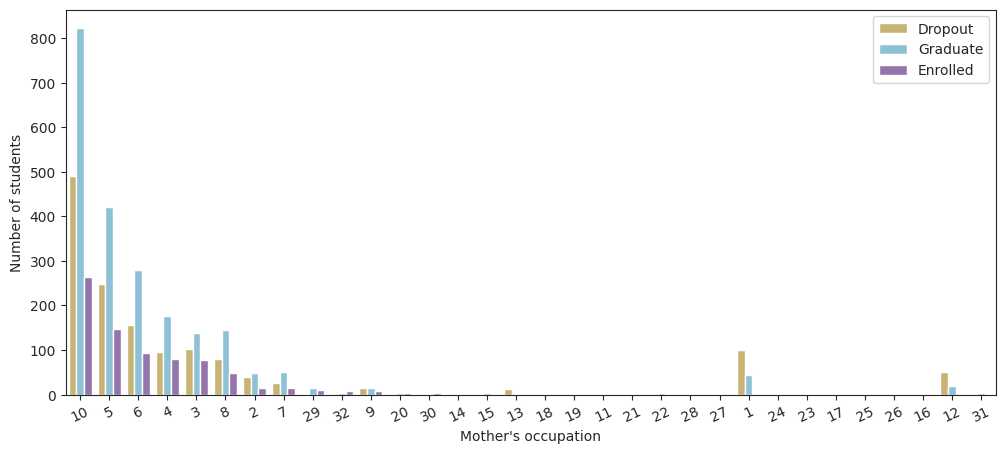

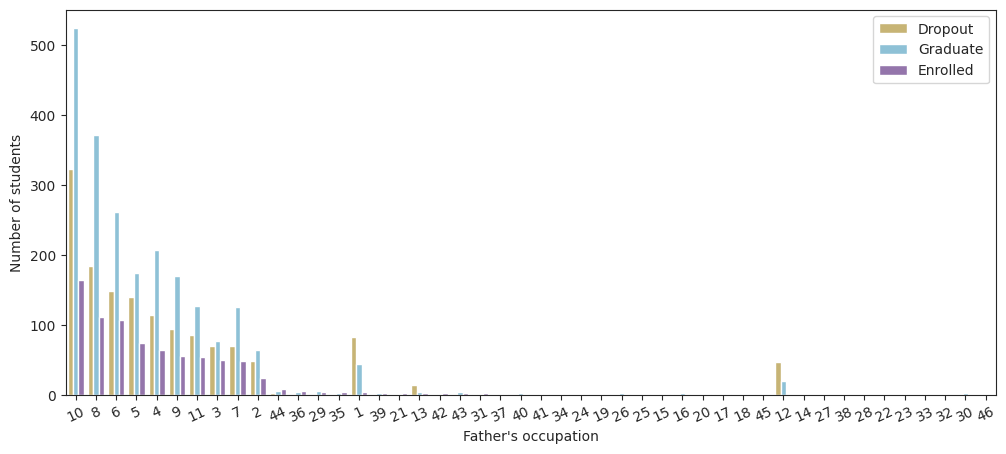

In [40]:
cols = ["Mother's occupation", "Father's occupation"]

# Create count plots.
for col in cols:
    fig, ax = plt.subplots(figsize=(12, 5))
    order = df[df['Target'] == 'Enrolled'][col].value_counts()
    ax = sns.countplot(data=df, x=col, hue='Target', palette=colors_target, order=order.index)
    ax.set(xlabel=col, ylabel='Number of students')
    plt.xticks(rotation=25)
    ax.legend_.set_title(None)
    plt.show()

### Displaced, Educational special needs, Debtor, Tuition fees up to date, Scholarship holder, International

In [41]:
cols = ['Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Scholarship holder', 'International']
# Replace 0 and 1 values with No and Yes respectively.
for col in cols:
    df = df.replace({col: {0: 'No', 1: 'Yes'}})

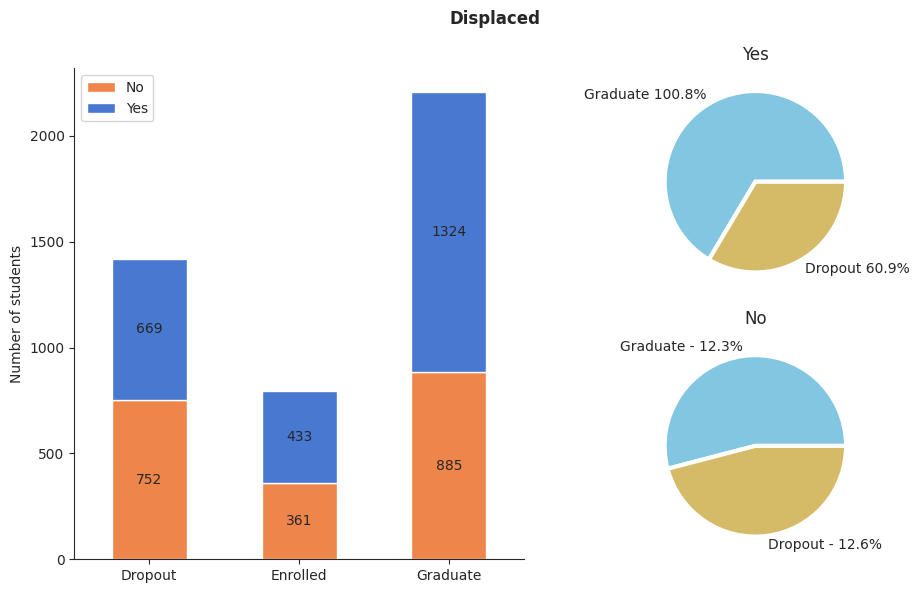

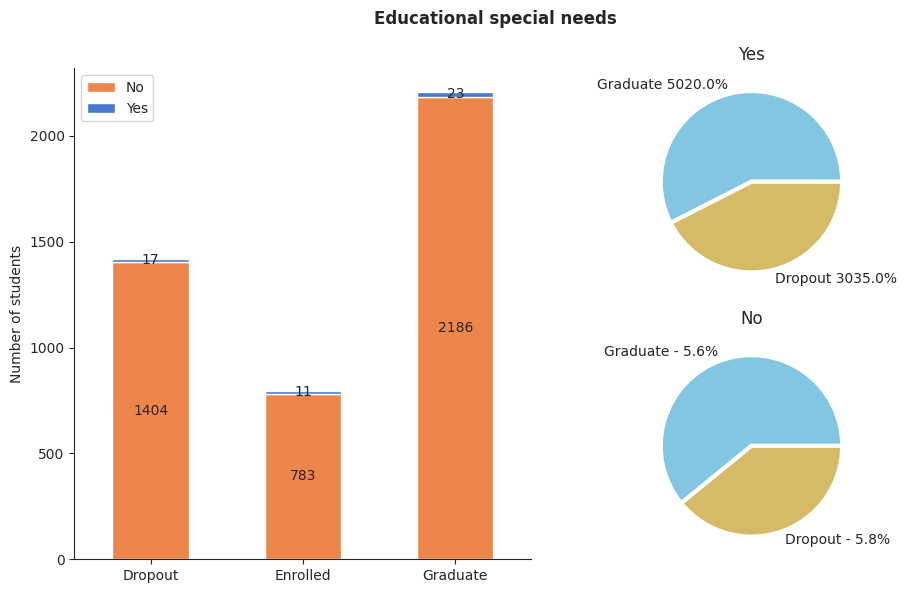

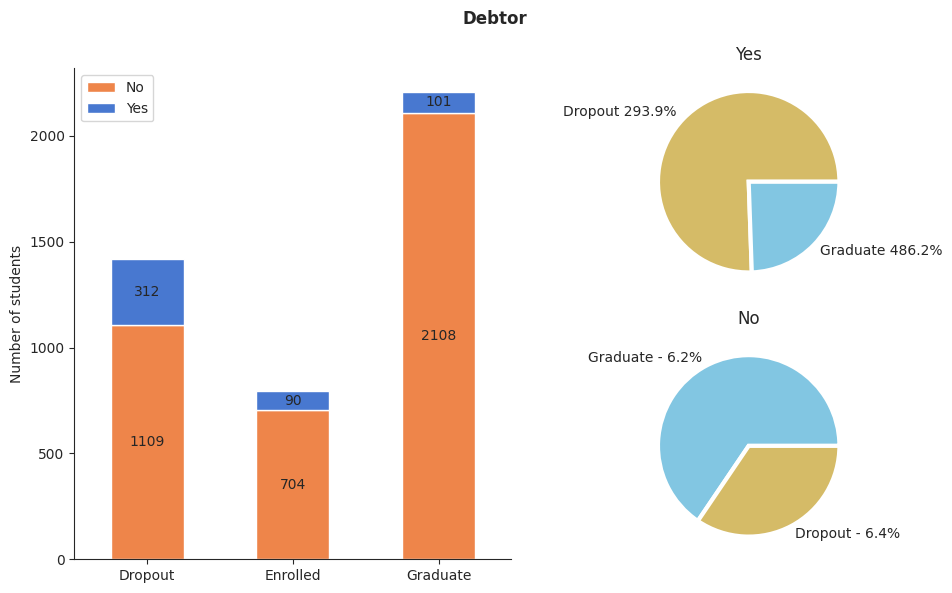

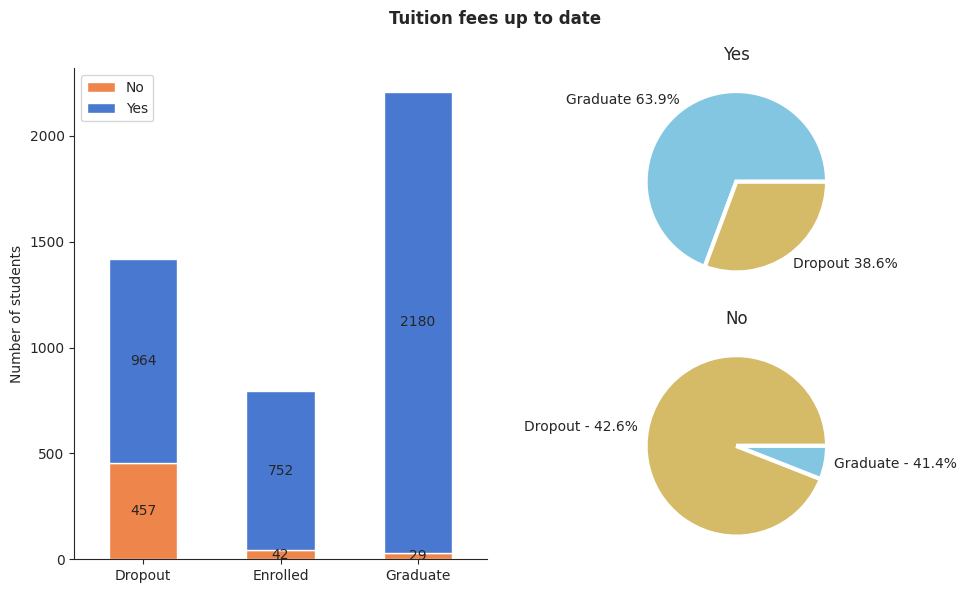

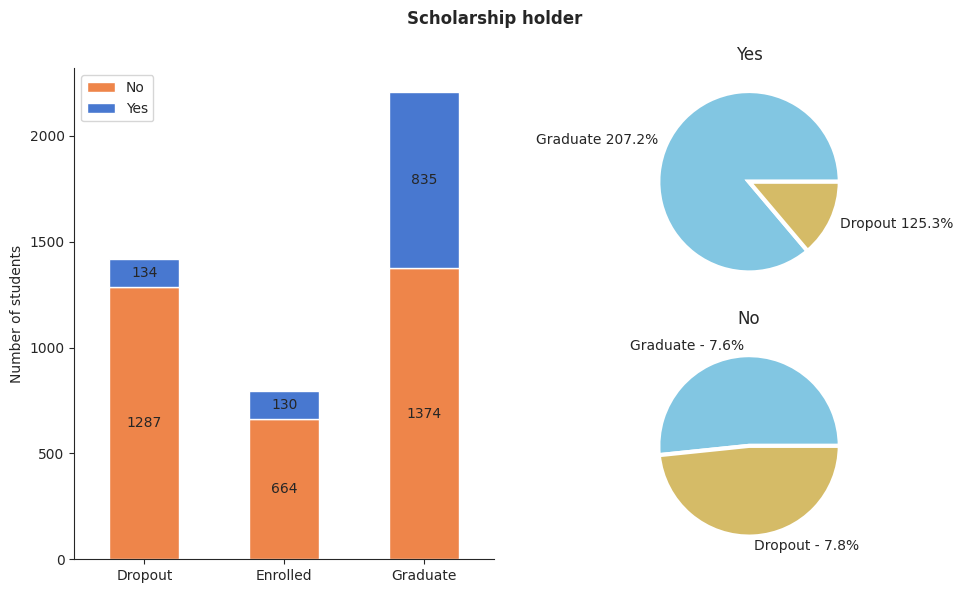

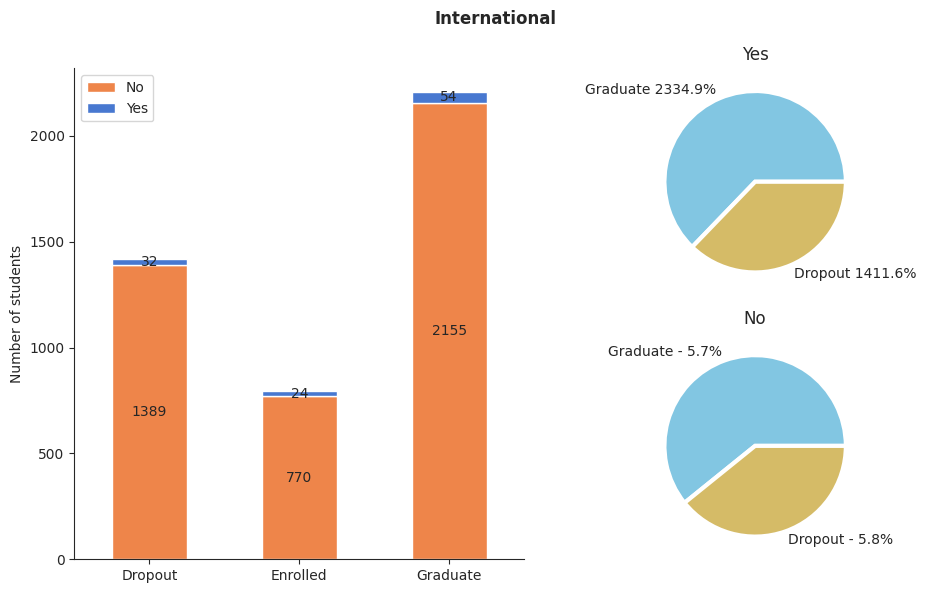

In [42]:
for col in cols:
    fig = plt.figure(figsize=(10, 6), tight_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=2)

    # Create a stacked barchart.
    ax1 = fig.add_subplot(gs[:, 0])
    data = df.groupby([col, 'Target']).size().reset_index().pivot(columns=col, 
                                                                  index='Target', values=0)
    data.plot(ax=ax1, kind='bar', stacked=True, color=[colors_binary.get(i) for i in data.columns])
    for cont in ax1.containers:
        ax1.bar_label(cont, label_type='center')
    ax1.spines[['right', 'top']].set_visible(False)
    ax1.set(xlabel=None, ylabel='Number of students')
    ax1.legend_.set_title(None)
    plt.xticks(rotation=0)

    # Create a pie chart with parameter Yes.
    yes = df[(df[col] == 'Yes') & (df['Target'] != 'Enrolled')]['Target'].value_counts()
    labels = [f'{label} {np.round(daytime[label] / yes.sum() * 100, 1)}%' for label in yes.index]
    ax2 = fig.add_subplot(gs[0, 1])
    patches, texts = ax2.pie(yes, labels=labels, colors=[colors_target.get(i) for i in yes.index], 
            wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'})
    ax2.set(title='Yes')

    # Create a pie chart with parameter No.
    no = df[(df[col] == 'No') & (df['Target'] != 'Enrolled')]['Target'].value_counts()
    labels = [f'{label} - {np.round(evening[label] / no.sum() * 100, 1)}%' for label in no.index]
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.pie(no, labels=labels, colors=[colors_target.get(i) for i in no.index], 
            wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'})
    ax3.set(title='No')
    
    fig.suptitle(col, weight='bold')
    
    plt.show()

### Continuous variables

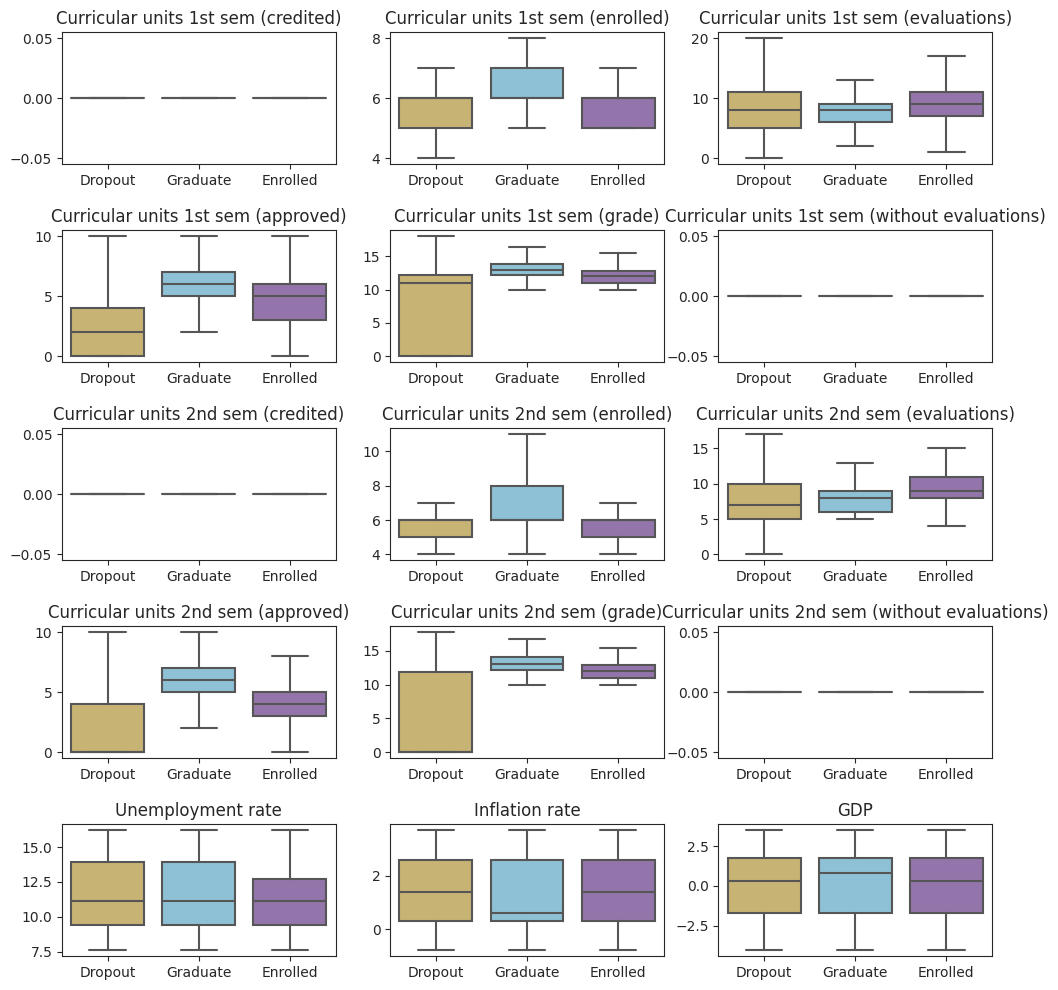

In [43]:
fig, axs = plt.subplots(5, 3, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
cols = ['Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP']

index = 0

for i in range(5):
    for j in range(3):
        sns.boxplot(df, x='Target', y=cols[index], showfliers=False, palette=colors_target, ax=axs[i, j])
        axs[i, j].set(xlabel=None, ylabel=None, title=cols[index])
        index += 1

## Feature engineering

In this section we will select important features, perform necessary changes to them and make the dataset ready for model building.

In [44]:
# Copy the original dataset.
df = students.copy()

Create an association matrix using `dython` library.

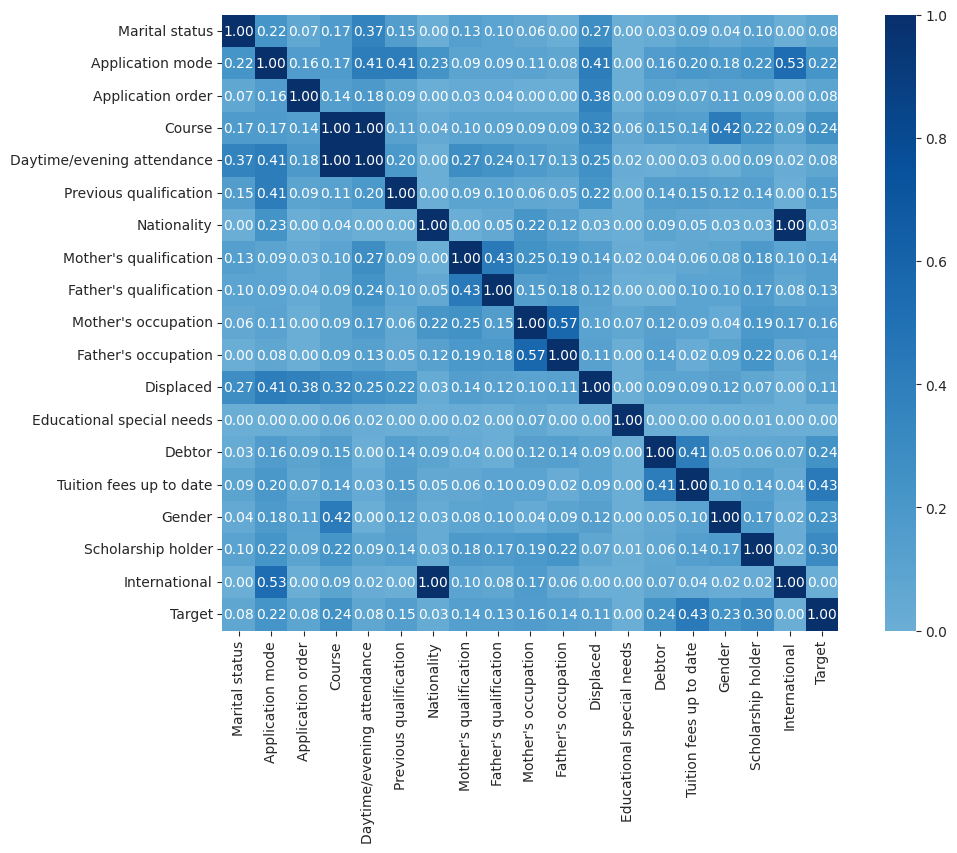

In [45]:
cols = ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 
        'Previous qualification', 'Nationality', "Mother's qualification", "Father's qualification", 
        "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 
        'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International', 'Target']

fig, ax = plt.subplots(figsize = (12, 8))

# Estimate and generate Cramer's V association plot.
cramers_v = associations(df[cols], nom_nom_assoc='cramer', ax=ax, cmap='Blues')

We see that some features have solid association with each other, these features are redundant and will not provide the model new information.\
Mother's occupation and Father's occupation have good association with each other (0.57). Keep only Mother's occupation as it has higher association with the Target.\
Mother's qualification and Father's qualification have good association with each other (0.43). Keep only Mother's qualification as it has higher association with the Target.\
Debtor and Tuition fees up to date have good association with each other (0.41). Keep only Tuition fees up to date as it has higher association with the Target.\
Displaced and Application mode have good association with each other (0.41). Keep only Application mode as it has higher association with the Target.
* According to the association matrix we will select following categorical features: `Application mode`, `Course`, `Previous qualification`, `Mother's qualification`, `Tuition fees up to date`, `Mother's occupation`, `Gender`, `Scholarship holder`.

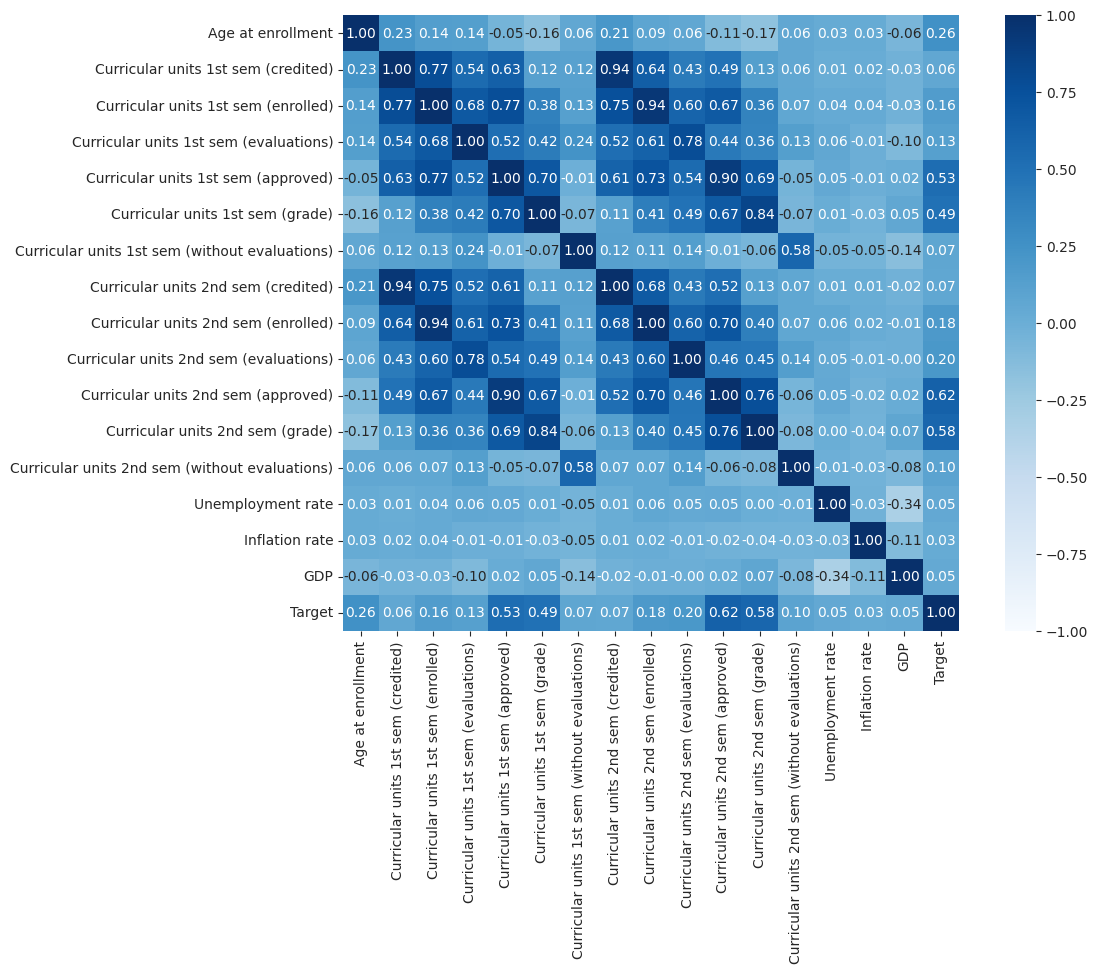

In [46]:
cols = ['Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 
           'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 
           'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 
           'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 
           'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 
           'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP', 'Target']

fig, ax = plt.subplots(figsize = (12, 8))

# Estimate and generate coorelation ratio association plot.
cor_ratio = associations(df[cols], nom_num_assoc='correlation_ratio', num_num_assoc='pearson', ax=ax, cmap='Blues')

* According to the association matrix we will select following categorical features: `Age at enrollment`, `Curricular units 1st sem (approved)`, `Curricular units 2nd sem (approved)`.

In [47]:
cols = ['Application mode', 'Course', 'Previous qualification', "Mother's qualification", 'Tuition fees up to date', 
        "Mother's occupation", 'Gender', 'Scholarship holder', 'Age at enrollment', 'Curricular units 1st sem (approved)', 
        'Curricular units 2nd sem (approved)', 'Target']

# Keep only relevant columns.
df = df[cols]

# Remove enrolled students.
df = df[df['Target'] != 'Enrolled']

# Convert into numerical data type.
df = df.replace({'Target': {'Dropout': 0, 'Graduate': 1}})
cols = ['Tuition fees up to date', 'Gender', 'Scholarship holder', 'Target']
df[cols] = df[cols].astype('int32')

# Perform one-hot encoding.
df = pd.get_dummies(df, drop_first=True)

The dataset is ready for model building.

## Model building

In [48]:
results = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [49]:
# Predicting variable.
y = df['Target']

# Predictor features.
X = df.copy()
X = X.drop('Target', axis = 1)

# Create training and test sets, 75% and 25% respectively.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [50]:
def conf_matrix_plot(model, x_data, y_data):

    model_pred = model.predict(x_data)
    cm = metrics.confusion_matrix(y_data, model_pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dropout', 'Graduate'], )  
    disp.plot(values_format='')
    plt.show()

In [51]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = metrics.roc_curve(true_y, y_prob)
    auc = metrics.roc_auc_score(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.text(0.95, 0.05, 'AUC = %0.3f' % auc, ha='right', weight='bold')

In [52]:
def print_results(algo, y_test, y_preds):
    
    global results
    print(algo)
    print("Accuracy:", "%.3f" % metrics.accuracy_score(y_test, y_preds))
    print("Precision:", "%.3f" % metrics.precision_score(y_test, y_preds))
    print("Recall:", "%.3f" % metrics.recall_score(y_test, y_preds))
    print("F1 Score:", "%.3f" % metrics.f1_score(y_test, y_preds))
    # Write results into a dataframe.
    row = {'Algorithm': algo, 'Accuracy': metrics.accuracy_score(y_test, y_preds), 
           'Precision': metrics.precision_score(y_test, y_preds), 'Recall': metrics.recall_score(y_test, y_preds), 
           'F1 Score': metrics.f1_score(y_test, y_preds)}
    results = pd.concat([results, pd.DataFrame(row, index=[0])], ignore_index=True)
    results = results.reset_index(drop=True)

### Naive Bayes

In [53]:
# Normalize data.
X_scaled_train = StandardScaler().fit_transform(X_train)
X_scaled_test = StandardScaler().fit_transform(X_test)
# Fit the model.
gnb = GaussianNB()
gnb.fit(X_scaled_train, y_train)
# Get the predictions on test data.
y_preds = gnb.predict(X_scaled_test)

In [54]:
print_results('Naive Bayes', y_test, y_preds)

Naive Bayes
Accuracy: 0.595
Precision: 0.595
Recall: 0.991
F1 Score: 0.744


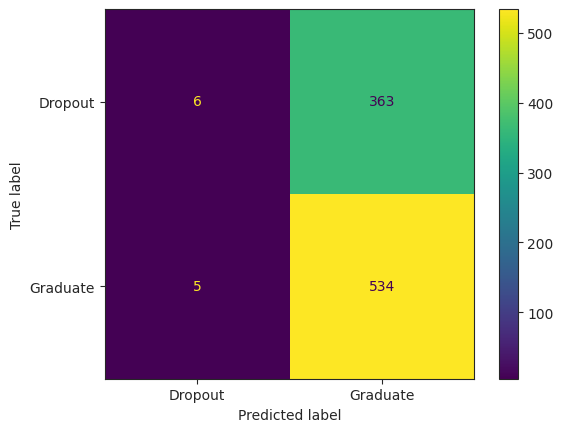

In [55]:
conf_matrix_plot(gnb, X_scaled_test, y_test)

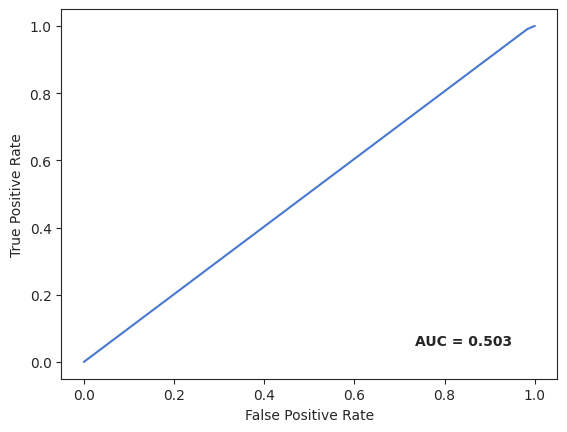

In [56]:
y_preds_prob_gnb = gnb.predict_proba(X_scaled_test)[:, 1]
plot_roc_curve(y_test, y_preds_prob_gnb)

### Logistic regression

In [57]:
X_scaled_train = StandardScaler().fit_transform(X_train)
X_scaled_test = StandardScaler().fit_transform(X_test)
lr = LogisticRegression()
lr.fit(X_scaled_train, y_train)
y_preds = lr.predict(X_scaled_test)

In [58]:
print_results('Logistic regression', y_test, y_preds)

Logistic regression
Accuracy: 0.887
Precision: 0.873
Recall: 0.946
F1 Score: 0.908


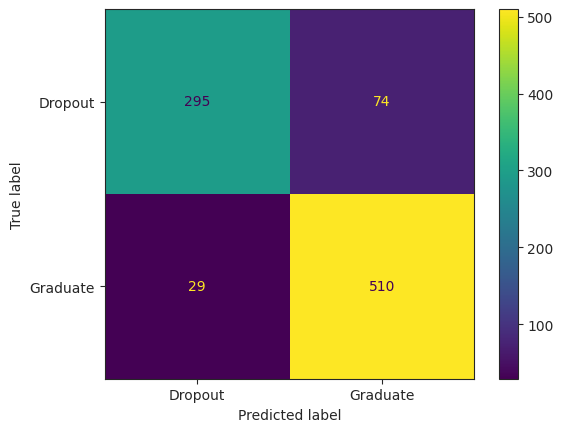

In [59]:
conf_matrix_plot(lr, X_scaled_test, y_test)

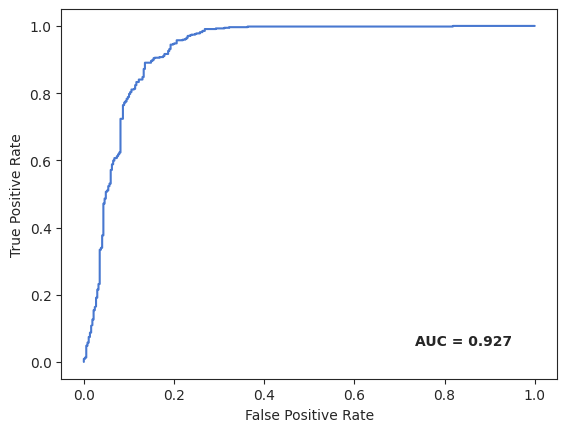

In [60]:
y_preds_prob_lr = lr.predict_proba(X_scaled_test)[:, 1]
plot_roc_curve(y_test, y_preds_prob_lr)

### SVM

In [61]:
X_scaled_train = StandardScaler().fit_transform(X_train)
X_scaled_test = StandardScaler().fit_transform(X_test)
svm = SVC(probability=True)
svm.fit(X_scaled_train, y_train)
y_preds = svm.predict(X_scaled_test)

In [62]:
print_results('SVM', y_test, y_preds)

SVM
Accuracy: 0.868
Precision: 0.844
Recall: 0.954
F1 Score: 0.895


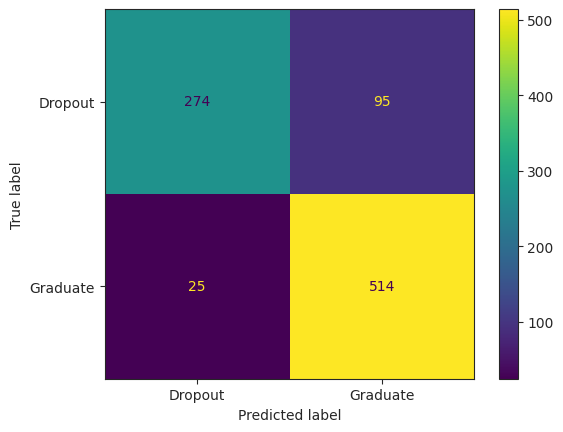

In [63]:
conf_matrix_plot(svm, X_scaled_test, y_test)

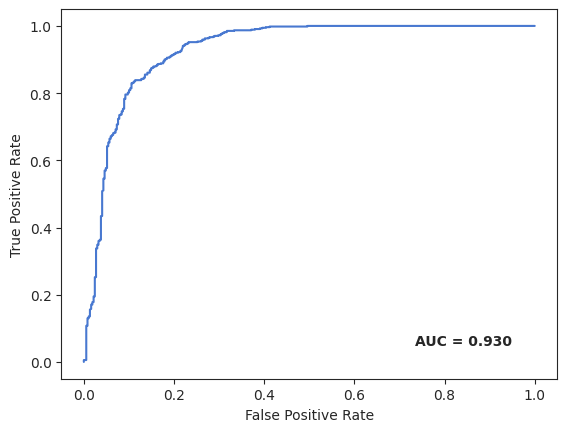

In [64]:
y_preds_prob_svm = svm.predict_proba(X_scaled_test)[:, 1]
plot_roc_curve(y_test, y_preds_prob_svm)

### Decision Tree

In [65]:
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train, y_train)
y_preds = decision_tree.predict(X_test)

In [66]:
print_results('Decision Tree', y_test, y_preds)

Decision Tree
Accuracy: 0.846
Precision: 0.874
Recall: 0.865
F1 Score: 0.869


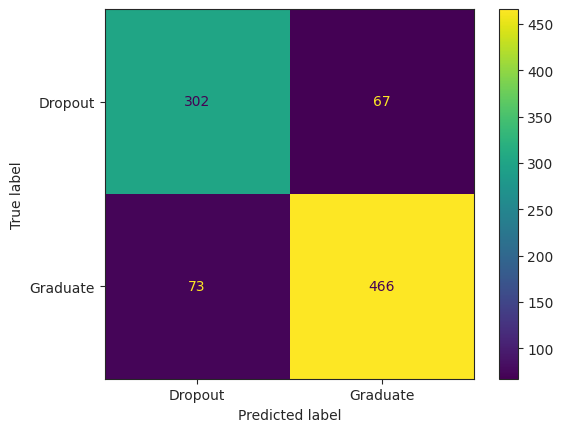

In [67]:
conf_matrix_plot(decision_tree, X_test, y_test)

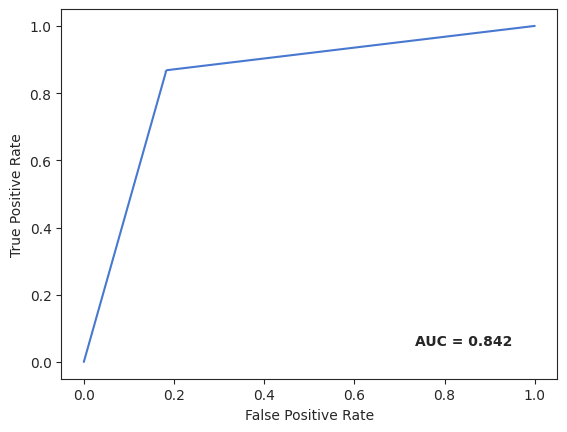

In [68]:
y_preds_prob_dt = decision_tree.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_preds_prob_dt)

### Random forest

In [69]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)

In [70]:
print_results('Random forest', y_test, y_preds)

Random forest
Accuracy: 0.904
Precision: 0.891
Recall: 0.955
F1 Score: 0.922


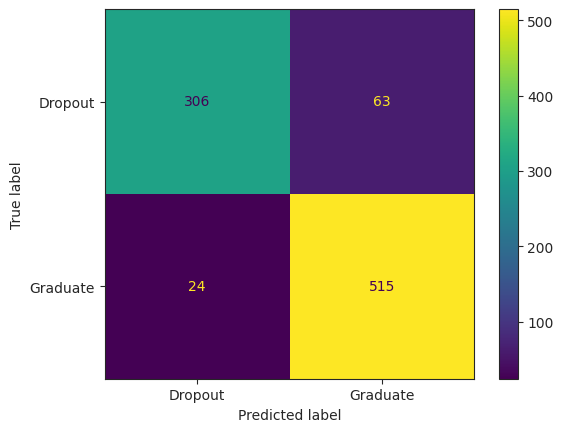

In [71]:
conf_matrix_plot(rf, X_test, y_test)

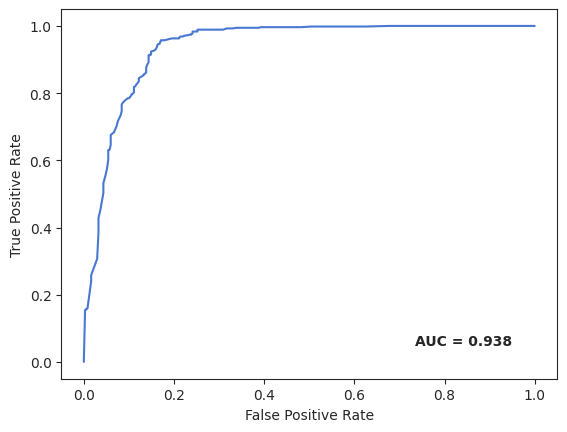

In [72]:
y_preds_prob_rf = rf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_preds_prob_rf)

### XGBoost

In [73]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)
xgb.fit(X_train, y_train)
y_preds = xgb.predict(X_test)

In [74]:
print_results('XGBoost', y_test, y_preds)

XGBoost
Accuracy: 0.889
Precision: 0.876
Recall: 0.946
F1 Score: 0.910


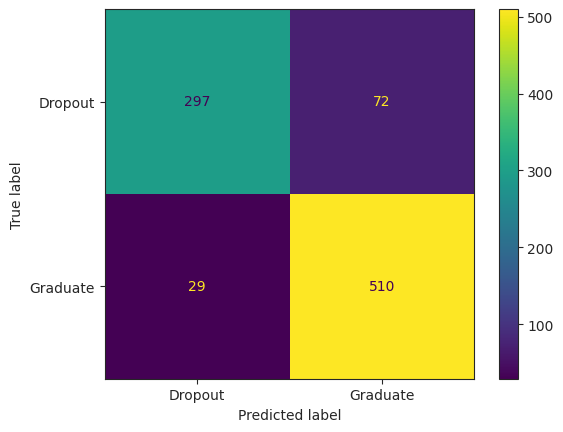

In [75]:
conf_matrix_plot(xgb, X_test, y_test)

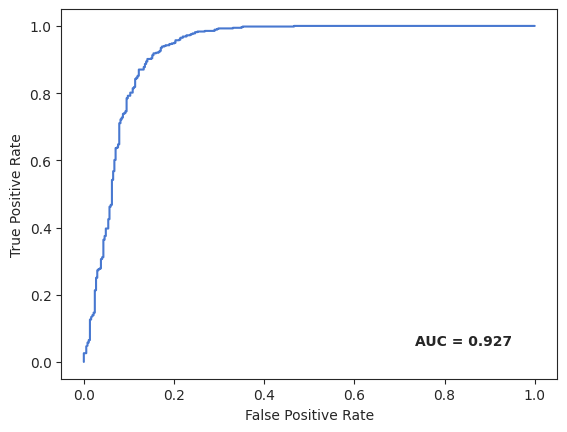

In [76]:
y_preds_prob_xgb = xgb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_preds_prob_xgb)

## Model evaluation

In [77]:
# Compare models.
results.sort_values(by=['Accuracy'], ascending=False)

,Algorithm,Accuracy,Precision,Recall,F1 Score
4,Random forest,0.904185,0.891003,0.955473,0.922113
5,XGBoost,0.888767,0.876289,0.946197,0.909902
1,Logistic regression,0.886564,0.873288,0.946197,0.908281
2,SVM,0.867841,0.844007,0.953618,0.895470
3,Decision Tree,0.845815,0.874296,0.864564,0.869403
0,Naive Bayes,0.594714,0.595318,0.990724,0.743733


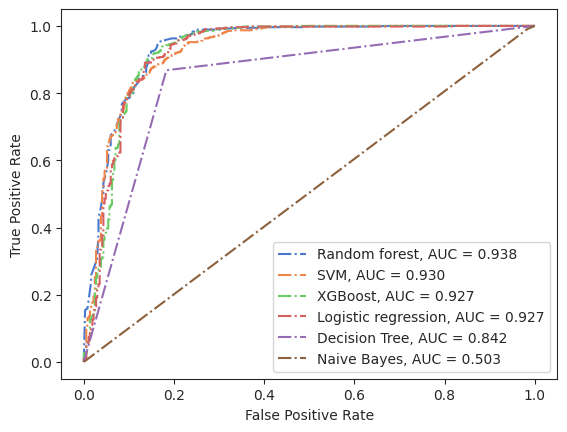

In [78]:
y_preds_probs = {'Naive Bayes': y_preds_prob_gnb, 'Logistic regression': y_preds_prob_lr, 'SVM': y_preds_prob_svm, 
                 'Decision Tree': y_preds_prob_dt, 'Random forest': y_preds_prob_rf, 'XGBoost': y_preds_prob_xgb}

aucs = {}
for i in y_preds_probs.keys():
    aucs[i] = metrics.roc_auc_score(y_test, y_preds_probs[i])
    
for i in dict(sorted(aucs.items(), key=operator.itemgetter(1), reverse=True)).keys():
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_probs[i])
    auc = aucs[i]
    plt.plot(fpr, tpr, linestyle='dashdot', label=f'{i}, AUC = {auc:.3f}')
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

## Hyperparameter tuning

In [79]:
# Determine set of hyperparameters.
cv_params = {'n_estimators' : [25, 50, 75, 100], 
              'max_depth' : [10, 30, 50, 70],        
              'min_samples_leaf' : [0.5, 0.75, 1], 
              'min_samples_split' : [0.001, 0.005, 0.01],
              'max_features' : ['sqrt'], 
              'max_samples' : [.3, .5, .7, .9]}

# Instantiate model.
rf = RandomForestClassifier(random_state=0)

# Search over specified parameters.
rf_val = GridSearchCV(rf, cv_params, cv=3, refit='accuracy', n_jobs = -1, verbose = 1)

# Fit the model.
rf_val.fit(X_train, y_train)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [10, 30, 50, 70],
                         'max_features': ['sqrt'],
                         'max_samples': [0.3, 0.5, 0.7, 0.9],
                         'min_samples_leaf': [0.5, 0.75, 1],
                         'min_samples_split': [0.001, 0.005, 0.01],
                         'n_estimators': [25, 50, 75, 100]},
             refit='accuracy', verbose=1)

In [80]:
# Obtain optimal parameters.
rf_val.best_params_

{'max_depth': 30,
 'max_features': 'sqrt',
 'max_samples': 0.3,
 'min_samples_leaf': 1,
 'min_samples_split': 0.001,
 'n_estimators': 50}

In [81]:
# Determine new set of hyperparameters.
cv_params = {'n_estimators' : [40, 45, 50, 55], 
              'max_depth' : [20, 25, 30, 35],        
              'min_samples_leaf' : [0.8, 0.9, 1], 
              'min_samples_split' : [0.0005, 0.001, 0.0015, 0.002],
              'max_features' : ['sqrt'], 
              'max_samples' : [.2, .25, .3, .35]}

rf = RandomForestClassifier(random_state=0)
rf_val = GridSearchCV(rf, cv_params, cv=3, refit='accuracy', n_jobs = -1, verbose = 1)
rf_val.fit(X_train, y_train)

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [20, 25, 30, 35],
                         'max_features': ['sqrt'],
                         'max_samples': [0.2, 0.25, 0.3, 0.35],
                         'min_samples_leaf': [0.8, 0.9, 1],
                         'min_samples_split': [0.0005, 0.001, 0.0015, 0.002],
                         'n_estimators': [40, 45, 50, 55]},
             refit='accuracy', verbose=1)

In [82]:
rf_val.best_params_

{'max_depth': 25,
 'max_features': 'sqrt',
 'max_samples': 0.3,
 'min_samples_leaf': 1,
 'min_samples_split': 0.0015,
 'n_estimators': 55}

In [83]:
rf_opt = RandomForestClassifier(n_estimators=55, max_depth=25, min_samples_leaf=1, 
                                min_samples_split=0.0015, max_features='sqrt', max_samples=0.3)
rf_opt.fit(X_train, y_train)
y_preds = rf_opt.predict(X_test)

In [84]:
# # Save the model.
# with open('model.pickle', 'wb') as f:
#     pickle.dump(rf_opt, f, pickle.HIGHEST_PROTOCOL)

In [85]:
print_results('Random forest', y_test, y_preds)

Random forest
Accuracy: 0.889
Precision: 0.875
Recall: 0.948
F1 Score: 0.910


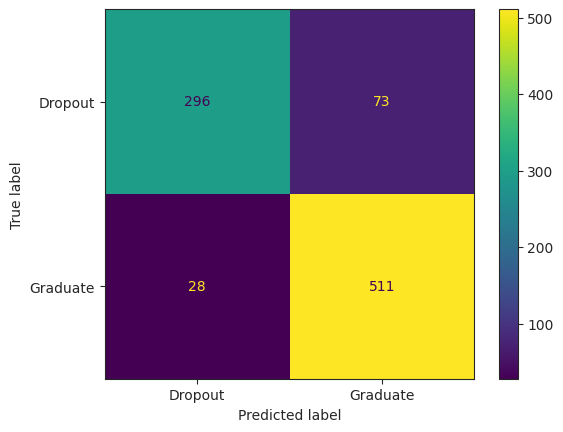

In [86]:
conf_matrix_plot(rf_opt, X_test, y_test)

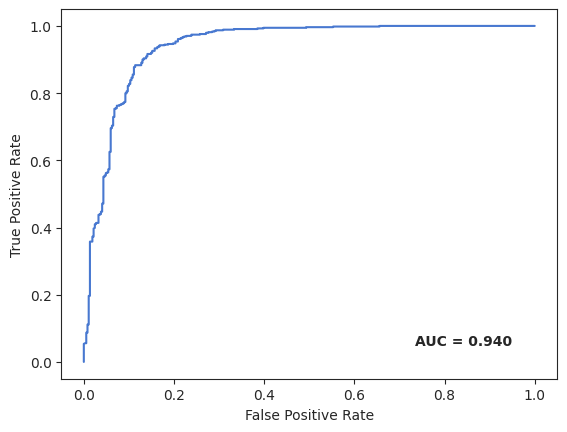

In [87]:
y_preds_prob = rf_opt.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_preds_prob)

## Prediction

Now we need to predict whether a student will graduate or drop out. For this purpose, we will be using students who are currently enrolled in studies.

In [88]:
# Make a copy of a dataframe
df = students.copy()

# Keep only enrolled students.
df = df[df['Target'] == 'Enrolled']

cols = ['Application mode', 'Course', 'Previous qualification', "Mother's qualification", 'Tuition fees up to date', 
        "Mother's occupation", 'Gender', 'Scholarship holder', 'Age at enrollment', 'Curricular units 1st sem (approved)', 
        'Curricular units 2nd sem (approved)']

# Make another copy of the dataframe with only relevant columns.
df_prediction = df[cols].copy()

# Convert into numerical data type.
cols = ['Tuition fees up to date', 'Gender', 'Scholarship holder']
df_prediction[cols] = df_prediction[cols].astype('int32')

# Perform one-hot encoding.
df_prediction = pd.get_dummies(df_prediction, drop_first=True)

In [89]:
# Perform prediction.
prediction = rf_opt.predict(df_prediction)

# Change enrolled to predicted outcome.
df['Target'] = prediction

df = df.replace({'Target': {0: 'Dropout', 1: 'Graduate'}})

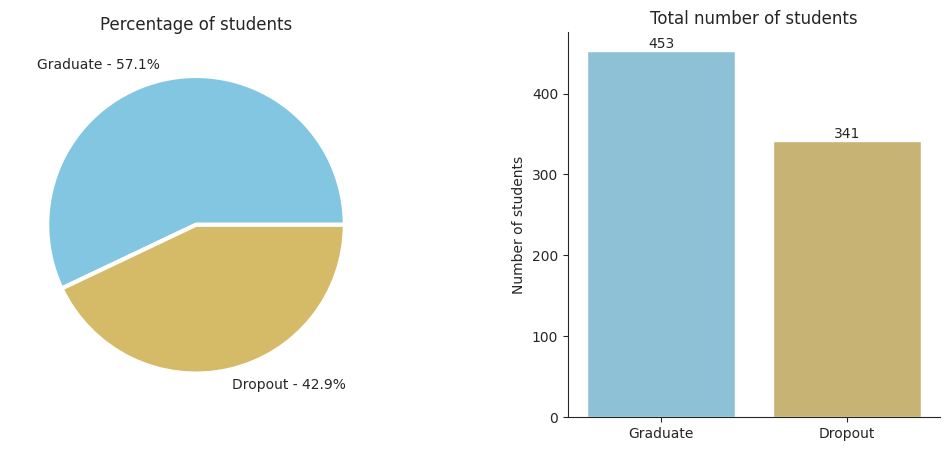

In [90]:
# Represent the predicted variable.
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.5)

data = df['Target'].value_counts()

# Create a pie chart.
labels = [f'{label} - {np.round(data[label] / data.sum() * 100, 1)}%' for label in data.index]
ax1.pie(data, labels=labels, wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'}, 
        colors=[colors_target.get(i) for i in data.index])
ax1.set_title('Percentage of students')

# Create a bar plot.
ax2 = sns.barplot(data=data.to_frame(), y='count', x=data.index, palette=colors_target)
ax2.set(xlabel=None, ylabel='Number of students')
ax2.bar_label(container=ax2.containers[0], labels=df['Target'].value_counts())
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_title('Total number of students')

plt.show()